# Install And Import Necessary Packages

In [ ]:
pip install pyreadstat torchvision pyjpegls python-gdcm -U pylibjpeg[all] pydicom albumentations --upgrade albumentations pyradiomics ultralytics timm timm_3d torchio mpl-tools

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import TensorDataset, DataLoader


import torchvision
from torchvision import datasets
import torchvision.models as models
from torchvision.transforms import v2
import torchvision.transforms as transforms


from torchvision.models import resnet34
from torchvision.transforms import Compose, RandomResizedCrop, Resize, ToTensor


# import radiomics
# from radiomics import featureextractor, getFeatureClasses
# from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm, shape2D


import sklearn
from sklearn import svm
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import cv2
import timm
import timm_3d
import pydicom
import pyreadstat
from PIL import Image
import torchio as tio
import SimpleITK as sitk
import albumentations as A
from IPython.display import clear_output
from data_complexity_measures.models.SeprationIndex import Kalhor_SeparationIndex


from accelerate.utils import set_seed
from accelerate import Accelerator, notebook_launcher

from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, XGradCAM, AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM,\
    LayerCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from medcam import medcam

# Define Necessary Functions And Set The Accelerator

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accelerator = Accelerator(mixed_precision="fp16")
device

device(type='cuda')

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

In [4]:
class TrainCustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform is not None:
            x = self.transform(image=x)["image"]
        return x, y

In [5]:
def albumentation_transform_applier(images, augmentation_transform):
    images = images.cpu().numpy()
    images_transformed = []
    for i in range(images.shape[0]):
        data = augmentation_transform(image=images[i, :, :, :])
        img = data['image']
        images_transformed.append(img)
    images  = torch.from_numpy(np.array(images_transformed).transpose(0, 3, 1, 2))
    return images

In [6]:
def transform_applier_3d(images, augmentation_transform):
    images = images.cpu()
    new_images = []
    for i in range(images.shape[0]):
        new_images.append(augmentation_transform(images[i, :, :, :, :]))
    new_images = torch.from_numpy(np.array(new_images))
    return new_images

In [7]:
def si_calculator(train_data, test_data, y_train, y_test):

    train_data_tensor = torch.from_numpy(train_data.reshape((len(train_data), 3*224*224)))
    test_data_tensor = torch.from_numpy(test_data.reshape((len(test_data), 3*224*224)))

    y_train_tensor = torch.from_numpy(np.array(y_train)).unsqueeze(1)
    y_test_tensor = torch.from_numpy(np.array(y_test)).unsqueeze(1)

    train_si_calculator = Kalhor_SeparationIndex(train_data_tensor, y_train_tensor, normalize=True)

    si_data = train_si_calculator.si_data()
    num_ones = torch.sum(si_data == 1).item()
    total_elements = si_data.numel()
    train_si = num_ones / total_elements

    cross_si_data = train_si_calculator.cross_si_data(test_data_tensor, y_test_tensor)
    num_ones = torch.sum(cross_si_data == True).item()
    total_elements = cross_si_data.numel()
    cross_si_test = num_ones / total_elements

    print(f"Train SI: {train_si}")
    print(f"Cross SI Test: {cross_si_test}")

In [8]:
def accuracy_per_class(y_true, y_pred):
  conf_matrix = confusion_matrix(y_true, y_pred)
  class_accuracy = {}
  for i in range(len(conf_matrix)):
    class_accuracy[i] = conf_matrix[i, i] / sum(conf_matrix[i])

  return class_accuracy

In [9]:
def model_parameters_number(model_name=None, model=None, model_type='2D'):
    if model_type == '2D':

        if (model_name == None) and (model != None):
            total_params = sum(p.numel() for p in model.parameters())
            print(f"Total number of parameters: {total_params/10**6:.2f} M")
        elif (model_name != None) and (model == None):
            model = timm.create_model(model_name, pretrained=True)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"Total number of parameters: {total_params/10**6:.2f} M")
        else:
            print("Please provide model_name or torch model!")

    else:

        if (model_name == None) and (model != None):
            total_params = sum(p.numel() for p in model.parameters())
            print(f"Total number of parameters: {total_params/10**6:.2f} M")
        elif (model_name != None) and (model == None):
            model = timm_3d.create_model(model_name, pretrained=True, num_classes=4, in_chans=1)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"Total number of parameters: {total_params/10**6:.2f} M")
        else:
            print("Please provide model_name or torch model!")

In [10]:
def timm_models_list():

    models_list_F = np.array(timm.list_models())
    models_list_T = np.array(timm.list_models(pretrained=True))
    models_list = np.concatenate((models_list_F, models_list_T), axis=0)
    models_list = np.unique(models_list)

    for model_name in models_list:
        print(model_name)

In [11]:
def timm_models_list_3D():

    models_list_F = np.array(timm_3d.list_models())
    models_list_T = np.array(timm_3d.list_models(pretrained=True))
    models_list = np.concatenate((models_list_F, models_list_T), axis=0)
    models_list = np.unique(models_list)

    for model_name in models_list:
        print(model_name)

In [12]:
def compute_class_weight(targets):
    class_counts = torch.bincount(targets)
    weight = 1.0 / class_counts
    weight = weight / weight.sum() * len(class_counts)
    return weight

In [13]:
def test_model(model, test_data_left, test_data_right, y_test, batch_size=1, is_3d=False):
  y_pred = []
  outputs_probability = []
  base_transform = transforms.Compose([transforms.ToTensor()])
  if is_3d:
      test_dataset_left = CustomDataset(test_data_left, y_test)
      test_dataset_right = CustomDataset(test_data_right, y_test)
  else:
      test_dataset_left = CustomDataset(test_data_left, y_test, transform=base_transform)
      test_dataset_right = CustomDataset(test_data_right, y_test, transform=base_transform)
  
  test_loader_left = torch.utils.data.DataLoader(test_dataset_left, batch_size=batch_size, shuffle=False)
  test_loader_right = torch.utils.data.DataLoader(test_dataset_right, batch_size=batch_size, shuffle=False)
  
  model.eval()
  test_correct = 0
  test_total = 0

  with torch.no_grad():
            for batch_idx_left, (images_left, labels_left) in enumerate(test_loader_left):
                for batch_idx_right, (images_right, labels_right) in enumerate(test_loader_right):
                    if batch_idx_right == batch_idx_left:

                        images_left = images_left.to(device)
                        labels_left = labels_left.to(device)

                        images_right = images_right.to(device)
                        labels_right = labels_right.to(device)

                        # Forward pass
                        outputs_left = model(images_left)
                        outputs_right = model(images_right)
                        
                        outputs = (outputs_left + outputs_right)/2
                        
                        _, predicted = torch.max(outputs.data, 1)

                        # Calculate test accuracy
                        test_total += labels_left.size(0)
                        test_correct += (predicted == labels_left).sum().item()

                        y_pred.append(predicted[0].cpu().numpy())
                        outputs_probability.append(outputs[0].cpu().numpy())

  y_pred = np.array(y_pred)
  outputs_probability = np.array(outputs_probability)
  
  # Calculate test accuracy
  test_accuracy = test_correct / test_total

  return y_pred, test_accuracy, outputs_probability

In [14]:
def model_trainer(model_name, batch_size, learning_rate, num_epochs, train_dataset, validation_dataset_left, validation_dataset_right, y_val, test_dataset_left, test_dataset_right, y_test, num_classes, in_chans, augmentation_transform, iteration_num, device, steps=15, save=False):
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_left = torch.utils.data.DataLoader(validation_dataset_left, batch_size=1, shuffle=False)
    val_loader_right = torch.utils.data.DataLoader(validation_dataset_right, batch_size=1, shuffle=False)
    test_loader_left = torch.utils.data.DataLoader(test_dataset_left, batch_size=1, shuffle=False)
    test_loader_right = torch.utils.data.DataLoader(test_dataset_right, batch_size=1, shuffle=False)
    
    test_accuracy_all = np.zeros(iteration_num)
    accuracy_train_all = np.zeros((iteration_num, num_epochs))
    accuracy_val_all = np.zeros((iteration_num, num_epochs))
    loss_train_all = np.zeros((iteration_num, num_epochs))
    loss_val_all = np.zeros((iteration_num, num_epochs))
    
    for i in range(iteration_num):
        
        print(f"iteration= {i}")

        with accelerator.main_process_first():
            model = timm.create_model(model_name, num_classes=num_classes, in_chans=in_chans, pretrained=True)  

        batch_size_train = len(train_loader)
        batch_size_val = len(val_loader_left)
        
        criterion = nn.CrossEntropyLoss() # label_smoothing=0.1
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=steps, gamma=0.1)

        model, optimizer, train_loader, val_loader_left, schedular = accelerator.prepare(
            model, optimizer, train_loader, val_loader_left, schedular
        )

        for epoch in range(num_epochs):

            # Training phase
            model.train()
            train_correct = 0
            train_total = 0
            total_loss = 0

            for batch_idx, (images, labels) in enumerate(train_loader):

                images = albumentation_transform_applier(images, augmentation_transform)
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                accelerator.backward(loss)

                # Backward pass and optimization
                optimizer.step()
                optimizer.zero_grad()

                # Accumulate the loss
                total_loss += loss.item()

                # Calculate train accuracy
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            # Calculate train accuracy
            train_accuracy = 100 * train_correct / train_total
            accuracy_train_all[i, epoch] = train_accuracy

            # Calculate the average loss for the epoch
            avg_train_loss = total_loss / batch_size_train
            loss_train_all[i, epoch] = avg_train_loss

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch_idx_left, (images_left, labels_left) in enumerate(val_loader_left):
                    for batch_idx_right, (images_right, labels_right) in enumerate(val_loader_right):
                        if batch_idx_right == batch_idx_left:
                            
                            images_left = images_left.to(device)
                            labels_left = labels_left.to(device)
                            
                            images_right = images_right.to(device)
                            labels_right = labels_right.to(device)

                            # Forward pass
                            outputs_left = model(images_left)
                            outputs_right = model(images_right)
                            
                            outputs = (outputs_left + outputs_right)/2
                            
                            _, predicted = torch.max(outputs.data, 1)

                            # Calculate validation loss
                            val_loss += criterion(outputs, labels_left).item()

                            # Calculate validation accuracy
                            val_total += labels_left.size(0)
                            val_correct += (predicted == labels_left).sum().item()

            # Calculate average validation loss and accuracy
            val_loss /= len(val_loader_left)
            
            loss_val_all[i, epoch] = val_loss

            val_accuracy = 100 * val_correct / val_total
            
            accuracy_val_all[i, epoch] = val_accuracy
            


            # Print train, validation metrics
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
            schedular.step()

        
        # Final test phase left
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_idx_left, (images_left, labels_left) in enumerate(test_loader_left):
                for batch_idx_right, (images_right, labels_right) in enumerate(test_loader_right):
                    if batch_idx_right == batch_idx_left:

                        images_left = images_left.to(device)
                        labels_left = labels_left.to(device)

                        images_right = images_right.to(device)
                        labels_right = labels_right.to(device)

                        # Forward pass
                        outputs_left = model(images_left)
                        outputs_right = model(images_right)
                        
                        outputs = (outputs_left + outputs_right)/2
                        
                        _, predicted = torch.max(outputs.data, 1)

                        # Calculate test accuracy
                        test_total += labels_left.size(0)
                        test_correct += (predicted == labels_left).sum().item()

#         Calculate test accuracy
        test_accuracy = 100 * test_correct / test_total

        test_accuracy_all[i] = test_accuracy

        # Print final test accuracy
        print(f"Final Test Accuracy: {test_accuracy:.2f}%")
        
        if save:
            torch.save(model, f"model{i}.pth")
    
    if save:
        np.save('accuracy_train_all.npy', accuracy_train_all)
        np.save('test_accuracy_all.npy', test_accuracy_all)
        np.save('accuracy_val_all.npy', accuracy_val_all)
        np.save('loss_train_all.npy', loss_train_all)
        np.save('loss_val_all.npy', loss_val_all)
        
    return accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all

In [15]:
def model_trainer_3d(model_name, batch_size, learning_rate, num_epochs, train_dataset, validation_dataset_left, validation_dataset_right, y_val, test_dataset_left, test_dataset_right, y_test, num_classes, in_chans, augmentation_transform, iteration_num, device, steps=15, pretrained=False, save=False):
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_left = torch.utils.data.DataLoader(validation_dataset_left, batch_size=1, shuffle=False)
    val_loader_right = torch.utils.data.DataLoader(validation_dataset_right, batch_size=1, shuffle=False)
    test_loader_left = torch.utils.data.DataLoader(test_dataset_left, batch_size=1, shuffle=False)
    test_loader_right = torch.utils.data.DataLoader(test_dataset_right, batch_size=1, shuffle=False)
    
    test_accuracy_all = np.zeros(iteration_num)
    accuracy_train_all = np.zeros((iteration_num, num_epochs))
    accuracy_val_all = np.zeros((iteration_num, num_epochs))
    loss_train_all = np.zeros((iteration_num, num_epochs))
    loss_val_all = np.zeros((iteration_num, num_epochs))
    
    for i in range(iteration_num):
        
        print(f"iteration= {i}")

        with accelerator.main_process_first():
            model = timm_3d.create_model(model_name, pretrained=pretrained, num_classes=num_classes, in_chans=in_chans)

        batch_size_train = len(train_loader)
        batch_size_val = len(val_loader_left)
        
        criterion = nn.CrossEntropyLoss() # label_smoothing=0.1
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
        schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=steps, gamma=0.1)

        model, optimizer, train_loader, val_loader, schedular = accelerator.prepare(
            model, optimizer, train_loader, val_loader_left, schedular
        )

        for epoch in range(num_epochs):

            # Training phase
            model.train()
            train_correct = 0
            train_total = 0
            total_loss = 0

            for batch_idx, (images, labels) in enumerate(train_loader):

                images = transform_applier_3d(images, augmentation_transform)
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                accelerator.backward(loss)

                # Backward pass and optimization
                optimizer.step()
                optimizer.zero_grad()

                # Accumulate the loss
                total_loss += loss.item()

                # Calculate train accuracy
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            # Calculate train accuracy
            train_accuracy = 100 * train_correct / train_total
            accuracy_train_all[i, epoch] = train_accuracy

            # Calculate the average loss for the epoch
            avg_train_loss = total_loss / batch_size_train
            loss_train_all[i, epoch] = avg_train_loss

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch_idx_left, (images_left, labels_left) in enumerate(val_loader_left):
                    for batch_idx_right, (images_right, labels_right) in enumerate(val_loader_right):
                        if batch_idx_right == batch_idx_left:
                            
                            images_left = images_left.to(device)
                            labels_left = labels_left.to(device)
                            
                            images_right = images_right.to(device)
                            labels_right = labels_right.to(device)

                            # Forward pass
                            outputs_left = model(images_left)
                            outputs_right = model(images_right)
                            
                            outputs = (outputs_left + outputs_right)/2
                            
                            _, predicted = torch.max(outputs.data, 1)

                            # Calculate validation loss
                            val_loss += criterion(outputs, labels_left).item()

                            # Calculate validation accuracy
                            val_total += labels_left.size(0)
                            val_correct += (predicted == labels_left).sum().item()

            # Calculate average validation loss and accuracy
            val_loss /= len(val_loader_left)
            
            loss_val_all[i, epoch] = val_loss

            val_accuracy = 100 * val_correct / val_total
            
            accuracy_val_all[i, epoch] = val_accuracy

            # Print train, validation metrics
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
            schedular.step()


        # Final test phase
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_idx_left, (images_left, labels_left) in enumerate(test_loader_left):
                for batch_idx_right, (images_right, labels_right) in enumerate(test_loader_right):
                    if batch_idx_right == batch_idx_left:

                        images_left = images_left.to(device)
                        labels_left = labels_left.to(device)

                        images_right = images_right.to(device)
                        labels_right = labels_right.to(device)

                        # Forward pass
                        outputs_left = model(images_left)
                        outputs_right = model(images_right)
                        
                        outputs = (outputs_left + outputs_right)/2
                        
                        _, predicted = torch.max(outputs.data, 1)

                        # Calculate test accuracy
                        test_total += labels_left.size(0)
                        test_correct += (predicted == labels_left).sum().item()

        # Calculate test accuracy
        test_accuracy = 100 * test_correct / test_total

        test_accuracy_all[i] = test_accuracy

        # Print final test accuracy
        print(f"Final Test Accuracy: {test_accuracy:.2f}%")
        
        if save:
            torch.save(model, f"model{i}.pth")
    
    if save:
        np.save('accuracy_train_all.npy', accuracy_train_all)
        np.save('test_accuracy_all.npy', test_accuracy_all)
        np.save('accuracy_val_all.npy', accuracy_val_all)
        np.save('loss_train_all.npy', loss_train_all)
        np.save('loss_val_all.npy', loss_val_all)
        
    return accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all

In [16]:
def average_metric_calculator(models_list, test_data_left, test_data_right, y_test, is_3d=False):
    average_kappa_list = []
    average_accuracy_list = []
    macro_average_specificity_list = []
    macro_average_precision_list = []
    macro_average_recall_list = []
    macro_average_f1_score_list = []

    for model in models_list:
        if is_3d:
            y_pred, _, _ = test_model(model, test_data_left, test_data_right, y_test, is_3d=is_3d)
        else:
            y_pred, _, _ = test_model(model, test_data_left, test_data_right, y_test)
            
        cm = confusion_matrix(y_test, y_pred)
        tp_c1 = cm[0, 0]
        tp_c2 = cm[1, 1]
        tp_c3 = cm[2, 2]
        tp_c4 = cm[3, 3]

        fp_c1 = cm[1, 0] + cm[2, 0] + cm[3, 0]
        fp_c2 = cm[0, 1] + cm[2, 1] + cm[3, 1]
        fp_c3 = cm[0, 2] + cm[1, 2] + cm[3, 2]
        fp_c4 = cm[0, 3] + cm[1, 3] + cm[2, 3]

        tn_c1 = cm[1, :].sum() + cm[2, :].sum() + cm[3, :].sum() - cm[1, 0] - cm[2, 0] - cm[3, 0]
        tn_c2 = cm[0, :].sum() + cm[2, :].sum() + cm[3, :].sum() - cm[0, 1] - cm[2, 1] - cm[3, 1]
        tn_c3 = cm[0, :].sum() + cm[1, :].sum() + cm[3, :].sum() - cm[0, 2] - cm[1, 2] - cm[3, 2]
        tn_c4 = cm[0, :].sum() + cm[1, :].sum() + cm[2, :].sum() - cm[0, 3] - cm[1, 3] - cm[2, 3]

        fn_c1 = cm[0, 1] + cm[0, 2] + cm[0, 3]
        fn_c2 = cm[1, 0] + cm[1, 2] + cm[1, 3]
        fn_c3 = cm[2, 0] + cm[2, 1] + cm[2, 3]
        fn_c4 = cm[3, 0] + cm[3, 1] + cm[3, 2]

        average_accuracy = (tp_c1 + tp_c2 + tp_c3 + tp_c4)/(tp_c1 + tp_c2 + tp_c3 + tp_c4 + fn_c1 + fn_c2 + fn_c3 + fn_c4)
        kappa = cohen_kappa_score(y_test, y_pred)

        specificity_c1 = tn_c1/(tn_c1 + fp_c1)
        specificity_c2 = tn_c2/(tn_c2 + fp_c2)
        specificity_c3 = tn_c3/(tn_c3 + fp_c3)
        specificity_c4 = tn_c4/(tn_c4 + fp_c4)
        macro_average_specificity = (specificity_c1 + specificity_c2 + specificity_c3 + specificity_c4)/4

        precision_c1 = tp_c1/(tp_c1 + fp_c1)
        precision_c2 = tp_c2/(tp_c2 + fp_c2)
        precision_c3 = tp_c3/(tp_c3 + fp_c3)
        precision_c4 = tp_c4/(tp_c4 + fp_c4)
        macro_average_precision = (precision_c1 + precision_c2 + precision_c3 + precision_c4)/4

        recall_c1 = tp_c1/(tp_c1 + fn_c1)
        recall_c2 = tp_c2/(tp_c2 + fn_c2)
        recall_c3 = tp_c3/(tp_c3 + fn_c3)
        recall_c4 = tp_c4/(tp_c4 + fn_c4)
        macro_average_recall = (recall_c1 + recall_c2 + recall_c3 + recall_c4)/4

        f1_score_c1 = 2 * (precision_c1 * recall_c1) / (precision_c1 + recall_c1)
        f1_score_c2 = 2 * (precision_c2 * recall_c2) / (precision_c2 + recall_c2)
        f1_score_c3 = 2 * (precision_c3 * recall_c3) / (precision_c3 + recall_c3)
        f1_score_c4 = 2 * (precision_c4 * recall_c4) / (precision_c4 + recall_c4)
        macro_average_f1_score = (f1_score_c1 + f1_score_c2 + f1_score_c3 + f1_score_c4)/4

        average_accuracy_list.append(average_accuracy)
        average_kappa_list.append(kappa)
        macro_average_specificity_list.append(macro_average_specificity)
        macro_average_precision_list.append(macro_average_precision)
        macro_average_recall_list.append(macro_average_recall)
        macro_average_f1_score_list.append(macro_average_f1_score)

    acc_mean = np.mean(average_accuracy_list)
    acc_std = np.std(average_accuracy_list)
    kappa_mean = np.mean(average_kappa_list)
    kappa_std = np.std(average_kappa_list)
    spec_mean = np.mean(macro_average_specificity_list)
    spec_std = np.std(macro_average_specificity_list)
    prec_mean = np.mean(macro_average_precision_list)
    prec_std = np.std(macro_average_precision_list)
    rec_mean = np.mean(macro_average_recall_list)
    rec_std = np.std(macro_average_recall_list)
    f1_mean = np.mean(macro_average_f1_score_list)
    f1_std = np.std(macro_average_f1_score_list)
    max_accuracy = np.max(average_accuracy_list)
    best_model_idx = np.argmax(average_accuracy_list)
    y_pred_best, _, outputs_probability_best = test_model(models_list[best_model_idx], test_data_left, test_data_right, y_test, is_3d=is_3d)

    return acc_mean, acc_std, kappa_mean, kappa_std, spec_mean, spec_std, prec_mean, prec_std, rec_mean, rec_std, f1_mean, f1_std, max_accuracy, best_model_idx, y_pred_best, outputs_probability_best

In [17]:
def reshape_transform(tensor, height=14, width=14):
    # Bring the channels to the first dimension, like in CNNs.
    result = tensor[:, :, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [18]:
def get_grad_cam(model, target_layer, test_data, test_data_path, data_idx, type=0, reshape_transform=None):
    
    grad_cam_img_list = []
    
    for idx in data_idx:
        
        img = test_data[idx, :, :, :]
        img = img[np.newaxis, :, :, :].transpose(0, 3, 1, 2)
        img = torch.from_numpy(img).to(device)
        
        test_data_r = np.load(test_data_path)
        img_n = test_data_r[idx, :, :, :].transpose(1, 2, 0)
        img_n = img_n/np.max(img_n).astype(np.float32)
        
        model.eval()
        
        if type == 0:
            if reshape_transform:
                cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=None)
        
        elif type == 1:
            if reshape_transform:
                cam = HiResCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = HiResCAM(model=model, target_layers=[target_layer], reshape_transform=None)
                
        elif type == 2:
            if reshape_transform:
                cam = GradCAMElementWise(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = GradCAMElementWise(model=model, target_layers=[target_layer], reshape_transform=None)
                
        elif type == 3:
            if reshape_transform:
                cam = GradCAMPlusPlus(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = GradCAMPlusPlus(model=model, target_layers=[target_layer], reshape_transform=None)
                
        elif type == 4:
            if reshape_transform:
                cam = XGradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = XGradCAM(model=model, target_layers=[target_layer], reshape_transform=None)

        elif type == 5:
            if reshape_transform:
                cam = AblationCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = AblationCAM(model=model, target_layers=[target_layer], reshape_transform=None)
                
        elif type == 6:
            if reshape_transform:
                cam = ScoreCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = ScoreCAM(model=model, target_layers=[target_layer], reshape_transform=None)
                
        elif type == 7:
            if reshape_transform:
                cam = EigenCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = EigenCAM(model=model, target_layers=[target_layer], reshape_transform=None)
                
        elif type == 8:
            if reshape_transform:
                cam = EigenGradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = EigenGradCAM(model=model, target_layers=[target_layer], reshape_transform=None)
                
        elif type == 9:
            if reshape_transform:
                cam = LayerCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = LayerCAM(model=model, target_layers=[target_layer], reshape_transform=None)
                
        elif type == 10:
            if reshape_transform:
                cam = FullGrad(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)
            else:
                cam = FullGrad(model=model, target_layers=[target_layer], reshape_transform=None)
                
        else:
            pass
            
        grayscale_cam = cam(input_tensor=img)
        grayscale_cam = grayscale_cam[0, :]
        
        grad_cam_img = show_cam_on_image(img_n, grayscale_cam, use_rgb=True)
        grad_cam_img_list.append(grad_cam_img)
        
    
    grad_cam_img_list = np.array(grad_cam_img_list) 
    
    return grad_cam_img_list

In [19]:
def kappa_CI(y_test, y_pred):

    n_samples = 5000
    bootstrap_samples = []
    for _ in range(n_samples):
        y_true_resampled, y_pred_resampled = resample(y_test, y_pred, replace=True)
        bootstrap_samples.append(cohen_kappa_score(y_true_resampled, y_pred_resampled))

    confidence_level = 0.95
    alpha = 1.0 - confidence_level
    lower_bound = np.quantile(bootstrap_samples, alpha / 2)
    upper_bound = np.quantile(bootstrap_samples, 1.0 - alpha / 2)

    return lower_bound, upper_bound

# Load Saved Best-Performing Models

In [20]:
fixed_path_2d = "E:/Final Models Results/Best Models/2D/"
fixed_path_3d = "E:/Final Models Results/Best Models/3D/"

mobilenetv2_050_best_model = timm.create_model('mobilenetv2_050', num_classes=4, in_chans=3, pretrained=False).to(device)
fine_tuned_model_weights = torch.load(fixed_path_2d + "mobilenetv2_050_best_model.pth", weights_only=False).state_dict()
mobilenetv2_050_best_model.load_state_dict(fine_tuned_model_weights)

resnet26_best_model = timm.create_model('resnet26', num_classes=4, in_chans=3, pretrained=False).to(device)
fine_tuned_model_weights = torch.load(fixed_path_2d + "resnet26_best_model.pth", weights_only=False).state_dict()
resnet26_best_model.load_state_dict(fine_tuned_model_weights)

resnet50_best_model = timm.create_model('resnet50', num_classes=4, in_chans=3, pretrained=False).to(device)
fine_tuned_model_weights = torch.load(fixed_path_2d + "resnet50_best_model.pth", weights_only=False).state_dict()
resnet50_best_model.load_state_dict(fine_tuned_model_weights)

cait_s24_224_best_model = timm.create_model('cait_s24_224', num_classes=4, in_chans=3, pretrained=False).to(device)
fine_tuned_model_weights = torch.load(fixed_path_2d + "cait_s24_224_best_model.pth", weights_only=False).state_dict()
cait_s24_224_best_model.load_state_dict(fine_tuned_model_weights)

densenet121_3d_best_model = timm_3d.create_model('densenet121', num_classes=4, in_chans=1, pretrained=False).to(device)
fine_tuned_model_weights = torch.load(fixed_path_3d + "densenet121_3d_best_model.pth", weights_only=False).state_dict()
densenet121_3d_best_model.load_state_dict(fine_tuned_model_weights)

resnet26_3d_best_model = timm_3d.create_model('resnet26', num_classes=4, in_chans=1, pretrained=False).to(device)
fine_tuned_model_weights = torch.load(fixed_path_3d + "resnet26_3d_best_model.pth", weights_only=False).state_dict()
resnet26_3d_best_model.load_state_dict(fine_tuned_model_weights)

resnet50_3d_best_model = timm_3d.create_model('resnet50', num_classes=4, in_chans=1, pretrained=False).to(device)
fine_tuned_model_weights = torch.load(fixed_path_3d + "resnet50_3d_best_model.pth", weights_only=False).state_dict()
resnet50_3d_best_model.load_state_dict(fine_tuned_model_weights)

<All keys matched successfully>

# 2D Analysis

In [21]:
fixed_path_train_validation = "E:/2D Dataset/Train and Validation/"
fixed_path_test = "E:/2D Dataset/Independent Test/"

train_data_2d = np.load(fixed_path_train_validation + "train_data_percentiles.npy")
validation_data_left_2d = np.load(fixed_path_train_validation + "validation_data_percentiles_left.npy")
validation_data_right_2d = np.load(fixed_path_train_validation + "validation_data_percentiles_right.npy")

test_data_left_2d = np.load(fixed_path_test + "test_data_percentiles_left.npy")
test_data_right_2d = np.load(fixed_path_test + "test_data_percentiles_right.npy")

y_train = np.array(np.load(fixed_path_train_validation + "train_labels_percentiles.npy"),  dtype=np.int64)
y_val = np.array(np.load(fixed_path_train_validation + "validation_labels_percentiles.npy"),  dtype=np.int64)
y_test = np.array(np.load(fixed_path_test + "test_labels_percentiles.npy"),  dtype=np.int64)

mean = np.mean(train_data_2d)
std = np.std(train_data_2d)

train_data_2d = (train_data_2d-mean)/std
validation_data_left_2d = (validation_data_left_2d-mean)/std
validation_data_right_2d = (validation_data_right_2d-mean)/std
test_data_left_2d = (test_data_left_2d-mean)/std
test_data_right_2d = (test_data_right_2d-mean)/std

train_data_2d = train_data_2d.transpose(0, 2, 3, 1).astype(np.float32)
validation_data_left_2d = validation_data_left_2d.transpose(0, 2, 3, 1).astype(np.float32)
validation_data_right_2d = validation_data_right_2d.transpose(0, 2, 3, 1).astype(np.float32)
test_data_left_2d = test_data_left_2d.transpose(0, 2, 3, 1).astype(np.float32)
test_data_right_2d = test_data_right_2d.transpose(0, 2, 3, 1).astype(np.float32)

class_weights = compute_class_weight(torch.from_numpy(y_train))
class_weights = class_weights.to(device)

In [33]:
si_calculator(train_data_2d, validation_data_right_2d, y_train, y_val)

data becomes normalized
Train SI: 0.45558375634517767
Cross SI Test: 0.45614035087719296


## Training Model mobilenetv2_050
### (1.97 M Parameters)

In [ ]:
p1 = 0.2
p2 = 0.5
p3 = 0.5
fill_value = -1

base_transform = transforms.Compose([transforms.ToTensor()])

augmentation_transform = A.Compose([
    A.Rotate(limit=(-45, 45), p=p1),
    A.RandomGridShuffle(grid=(14,14), p=p1),
    A.VerticalFlip(p=p1),
    A.HorizontalFlip(p=p1),
])

data = augmentation_transform(image=train_data_2d[0])
img = data['image']
plt.imshow(img[:, :, 1], cmap='gray')

In [ ]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50
model_name = 'mobilenetv2_050'
num_classes = 4
in_chans = 3
iteration_num = 20
steps = 15

train_dataset = CustomDataset(train_data_2d, y_train)
validation_dataset_left = CustomDataset(validation_data_left_2d, y_val, transform=base_transform)
validation_dataset_right = CustomDataset(validation_data_right_2d, y_val, transform=base_transform)
test_dataset_left = CustomDataset(test_data_left_2d, y_test, transform=base_transform)
test_dataset_right = CustomDataset(test_data_right_2d, y_test, transform=base_transform)

accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all = model_trainer(model_name=model_name,
              batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, 
              train_dataset=train_dataset, validation_dataset_left=validation_dataset_left, 
              validation_dataset_right=validation_dataset_right, y_val=y_val, test_dataset_left=test_dataset_left,
              test_dataset_right=test_dataset_right, y_test=y_test,
              num_classes=num_classes, in_chans=in_chans, augmentation_transform=augmentation_transform,
              iteration_num=iteration_num, device=device, steps=steps, save=True)

In [20]:
models_path = "E:/Final Models Results/2D/mobilenetv2_050/"
models_list = []

for i in range(10):
  model = timm.create_model('mobilenetv2_050', num_classes=4, in_chans=3, pretrained=False).to(device)
  fine_tuned_model_weights = torch.load(models_path + f"model{i}.pth", weights_only=False).state_dict()
  model.load_state_dict(fine_tuned_model_weights)
  models_list.append(model)

accuracy_train_all = np.load(models_path + "accuracy_train_all.npy")/100
accuracy_val_all = np.load(models_path + "accuracy_val_all.npy")/100
loss_train_all = np.load(models_path + "loss_train_all.npy")
loss_val_all = np.load(models_path + "loss_val_all.npy")

train_acc_avg_mobilenetv2_050_2d = np.mean(accuracy_train_all, axis=0)
val_acc_avg_mobilenetv2_050_2d = np.mean(accuracy_val_all, axis=0)

train_loss_avg_mobilenetv2_050_2d = np.mean(loss_train_all, axis=0)
val_loss_avg_mobilenetv2_050_2d = np.mean(loss_val_all, axis=0)

In [54]:
acc_mean, acc_std, kappa_mean, kappa_std, spec_mean, spec_std, prec_mean, prec_std,\
 rec_mean, rec_std, f1_mean, f1_std, max_accuracy, best_model_idx,\
  y_pred_best_mobilenetv2_050, output_probability_best_mobilenetv2_050 = average_metric_calculator(models_list, test_data_left_2d, test_data_right_2d, y_test)

mobilenetv2_050_best_model = models_list[best_model_idx]

print(f"Mean Test Accuracy: {acc_mean:.3f}")
print(f"Standard Deviation of the Test Accuracy: {acc_std:.3f}")
print(f"Maximum Test Accuracy: {max_accuracy:.3f}")
print(f"Index of Model with Maximum Test Accuracy: {best_model_idx}")
print(50*'#')
print(f"Mean Specificity: {spec_mean:.3f}")
print(f"Standard Deviation of the Specificity: {spec_std:.3f}")
print(50*'#')
print(f"Mean Precision: {prec_mean:.3f}")
print(f"Standard Deviation of the Precision: {prec_std:.3f}")
print(50*'#')
print(f"Mean Recall: {rec_mean:.3f}")
print(f"Standard Deviation of the Recall: {rec_std:.3f}")
print(50*'#')
print(f"Mean F1 Score: {f1_mean:.3f}")
print(f"Standard Deviation of the F1 Score: {f1_std:.3f}")
print(50*'#')
print(f"Mean kappa score: {kappa_mean:.3f}")
print(f"Standard Deviation of kappa Score: {kappa_std:.3f}")

Mean Test Accuracy: 0.760
Standard Deviation of the Test Accuracy: 0.025
Maximum Test Accuracy: 0.808
Index of Model with Maximum Test Accuracy: 6
##################################################
Mean Specificity: 0.911
Standard Deviation of the Specificity: 0.010
##################################################
Mean Precision: 0.836
Standard Deviation of the Precision: 0.018
##################################################
Mean Recall: 0.695
Standard Deviation of the Recall: 0.033
##################################################
Mean F1 Score: 0.724
Standard Deviation of the F1 Score: 0.033
##################################################
Mean kappa score: 0.653
Standard Deviation of kappa Score: 0.037


In [55]:
acc, _, kappa, _, spec, _, prec, _,\
 rec, _, f1, _, _, _,\
  _, _ = average_metric_calculator([models_list[best_model_idx]], test_data_left_2d, test_data_right_2d, y_test)

lower_kappa_CI, upper_kappa_CI = kappa_CI(y_test, y_pred_best_mobilenetv2_050)

print(f"Test Accuracy of the Best Model: {acc:.3f}")
print(f"Specificity of the Best Model: {spec:.3f}")
print(f"Precision of the Best Model: {prec:.3f}")
print(f"Recall of the Best Model: {rec:.3f}")
print(f"F1 Score of the Best Model: {f1:.3f}")
print(f"Kappa score of the Best Model: {kappa:.3f}")
print(f"Kappa CI of the Best Model: [{lower_kappa_CI:.3f}, {upper_kappa_CI:.3f}]")

Test Accuracy of the Best Model: 0.808
Specificity of the Best Model: 0.929
Precision of the Best Model: 0.868
Recall of the Best Model: 0.762
F1 Score of the Best Model: 0.792
Kappa score of the Best Model: 0.725
Kappa CI of the Best Model: [0.611, 0.830]


In [38]:
# Best Model Results
print(classification_report(y_test, y_pred_best_mobilenetv2_050, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.556     0.714         9
           1      0.725     0.967     0.829        30
           2      0.800     0.778     0.789        36
           3      0.947     0.750     0.837        24

    accuracy                          0.808        99
   macro avg      0.868     0.762     0.792        99
weighted avg      0.831     0.808     0.806        99


## Training Model resnet26
### (16 M Parameters)

In [ ]:
p1 = 0.5
p2 = 0.5
p3 = 0.5
fill_value = -1

base_transform = transforms.Compose([transforms.ToTensor()])

augmentation_transform = A.Compose([
    A.Rotate(limit=(0, 360), p=p1),
    A.RandomGridShuffle(grid=(14,14), p=p1),
    A.VerticalFlip(p=p1),
    A.HorizontalFlip(p=p1),
])

data = augmentation_transform(image=train_data_2d[0])
img = data['image']
plt.imshow(img[:, :, 1], cmap='gray')

In [ ]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50
model_name = 'resnet26'
num_classes = 4
in_chans = 3
iteration_num = 10
steps = 15

train_dataset = CustomDataset(train_data_2d, y_train)
validation_dataset_left = CustomDataset(validation_data_left_2d, y_val, transform=base_transform)
validation_dataset_right = CustomDataset(validation_data_right_2d, y_val, transform=base_transform)
test_dataset_left = CustomDataset(test_data_left_2d, y_test, transform=base_transform)
test_dataset_right = CustomDataset(test_data_right_2d, y_test, transform=base_transform)

accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all = model_trainer(model_name=model_name,
              batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, 
              train_dataset=train_dataset, validation_dataset_left=validation_dataset_left, 
              validation_dataset_right=validation_dataset_right, y_val=y_val, test_dataset_left=test_dataset_left,
              test_dataset_right=test_dataset_right, y_test=y_test,
              num_classes=num_classes, in_chans=in_chans, augmentation_transform=augmentation_transform,
              iteration_num=iteration_num, device=device, steps=steps, save=True)

In [21]:
models_path = "E:/Final Models Results/2D/resnet26/"
models_list = []

for i in range(10):
  model = timm.create_model('resnet26', num_classes=4, in_chans=3, pretrained=False).to(device)
  fine_tuned_model_weights = torch.load(models_path + f"model{i}.pth", weights_only=False).state_dict()
  model.load_state_dict(fine_tuned_model_weights)
  models_list.append(model)

accuracy_train_all = np.load(models_path + "accuracy_train_all.npy")/100
accuracy_val_all = np.load(models_path + "accuracy_val_all.npy")/100
loss_train_all = np.load(models_path + "loss_train_all.npy")
loss_val_all = np.load(models_path + "loss_val_all.npy")

train_acc_avg_resnet26_2d = np.mean(accuracy_train_all, axis=0)
val_acc_avg_resnet26_2d = np.mean(accuracy_val_all, axis=0)

train_loss_avg_resnet26_2d = np.mean(loss_train_all, axis=0)
val_loss_avg_resnet26_2d = np.mean(loss_val_all, axis=0)

In [57]:
acc_mean, acc_std, kappa_mean, kappa_std, spec_mean, spec_std, prec_mean, prec_std,\
 rec_mean, rec_std, f1_mean, f1_std, max_accuracy, best_model_idx,\
  y_pred_best_resnet26, output_probability_best_resnet26 = average_metric_calculator(models_list, test_data_left_2d, test_data_right_2d, y_test)

resnet26_best_model = models_list[best_model_idx]

print(f"Mean Test Accuracy: {acc_mean:.3f}")
print(f"Standard Deviation of the Test Accuracy: {acc_std:.3f}")
print(f"Maximum Test Accuracy: {max_accuracy:.3f}")
print(f"Index of Model with Maximum Test Accuracy: {best_model_idx}")
print(50*'#')
print(f"Mean Specificity: {spec_mean:.3f}")
print(f"Standard Deviation of the Specificity: {spec_std:.3f}")
print(50*'#')
print(f"Mean Precision: {prec_mean:.3f}")
print(f"Standard Deviation of the Precision: {prec_std:.3f}")
print(50*'#')
print(f"Mean Recall: {rec_mean:.3f}")
print(f"Standard Deviation of the Recall: {rec_std:.3f}")
print(50*'#')
print(f"Mean F1 Score: {f1_mean:.3f}")
print(f"Standard Deviation of the F1 Score: {f1_std:.3f}")
print(50*'#')
print(f"Mean kappa score: {kappa_mean:.3f}")
print(f"Standard Deviation of kappa Score: {kappa_std:.3f}")

Mean Test Accuracy: 0.786
Standard Deviation of the Test Accuracy: 0.016
Maximum Test Accuracy: 0.808
Index of Model with Maximum Test Accuracy: 2
##################################################
Mean Specificity: 0.921
Standard Deviation of the Specificity: 0.006
##################################################
Mean Precision: 0.815
Standard Deviation of the Precision: 0.020
##################################################
Mean Recall: 0.735
Standard Deviation of the Recall: 0.024
##################################################
Mean F1 Score: 0.759
Standard Deviation of the F1 Score: 0.023
##################################################
Mean kappa score: 0.693
Standard Deviation of kappa Score: 0.024


In [58]:
acc, _, kappa, _, spec, _, prec, _,\
 rec, _, f1, _, _, _,\
  _, _ = average_metric_calculator([models_list[best_model_idx]], test_data_left_2d, test_data_right_2d, y_test)

lower_kappa_CI, upper_kappa_CI = kappa_CI(y_test, y_pred_best_resnet26)

print(f"Test Accuracy of the Best Model: {acc:.3f}")
print(f"Specificity of the Best Model: {spec:.3f}")
print(f"Precision of the Best Model: {prec:.3f}")
print(f"Recall of the Best Model: {rec:.3f}")
print(f"F1 Score of the Best Model: {f1:.3f}")
print(f"Kappa score of the Best Model: {kappa:.3f}")
print(f"Kappa CI of the Best Model: [{lower_kappa_CI:.3f}, {upper_kappa_CI:.3f}]")

Test Accuracy of the Best Model: 0.808
Specificity of the Best Model: 0.930
Precision of the Best Model: 0.830
Recall of the Best Model: 0.760
F1 Score of the Best Model: 0.783
Kappa score of the Best Model: 0.725
Kappa CI of the Best Model: [0.606, 0.829]


In [42]:
# Best Model Results
print(classification_report(y_test, y_pred_best_resnet26, digits=3))

              precision    recall  f1-score   support

           0      0.833     0.556     0.667         9
           1      0.750     0.900     0.818        30
           2      0.789     0.833     0.811        36
           3      0.947     0.750     0.837        24

    accuracy                          0.808        99
   macro avg      0.830     0.760     0.783        99
weighted avg      0.820     0.808     0.806        99


## Training Model resnet50
### (25.56 M Parameters)

In [ ]:
p1 = 0.8
p2 = 0.5
p3 = 0.5
fill_value = -1

base_transform = transforms.Compose([transforms.ToTensor()])

augmentation_transform = A.Compose([
    A.ChannelShuffle(p=p1),
    A.Rotate(limit=(0, 360), p=p1),
    A.VerticalFlip(p=p1),
    A.HorizontalFlip(p=p1),
    A.Blur(blur_limit=9, p=p1),
])

data = augmentation_transform(image=train_data_2d[0])
img = data['image']
plt.imshow(img[:, :, 1], cmap='gray')

In [ ]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50
model_name = 'resnet50'
num_classes = 4
in_chans = 3
iteration_num = 10
steps = 15

train_dataset = CustomDataset(train_data_2d, y_train)
validation_dataset_left = CustomDataset(validation_data_left_2d, y_val, transform=base_transform)
validation_dataset_right = CustomDataset(validation_data_right_2d, y_val, transform=base_transform)
test_dataset_left = CustomDataset(test_data_left_2d, y_test, transform=base_transform)
test_dataset_right = CustomDataset(test_data_right_2d, y_test, transform=base_transform)

accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all = model_trainer(model_name=model_name,
              batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, 
              train_dataset=train_dataset, validation_dataset_left=validation_dataset_left, 
              validation_dataset_right=validation_dataset_right, y_val=y_val, test_dataset_left=test_dataset_left,
              test_dataset_right=test_dataset_right, y_test=y_test,
              num_classes=num_classes, in_chans=in_chans, augmentation_transform=augmentation_transform,
              iteration_num=iteration_num, device=device, steps=steps, save=True)

In [22]:
models_path = "E:/Final Models Results/2D/resnet50/"
models_list = []

for i in range(10):
  model = timm.create_model('resnet50', num_classes=4, in_chans=3, pretrained=False).to(device)
  fine_tuned_model_weights = torch.load(models_path + f"model{i}.pth", weights_only=False).state_dict()
  model.load_state_dict(fine_tuned_model_weights)
  models_list.append(model)

accuracy_train_all = np.load(models_path + "accuracy_train_all.npy")/100
accuracy_val_all = np.load(models_path + "accuracy_val_all.npy")/100
loss_train_all = np.load(models_path + "loss_train_all.npy")
loss_val_all = np.load(models_path + "loss_val_all.npy")

train_acc_avg_resnet50_2d = np.mean(accuracy_train_all, axis=0)
val_acc_avg_resnet50_2d = np.mean(accuracy_val_all, axis=0)

train_loss_avg_resnet50_2d = np.mean(loss_train_all, axis=0)
val_loss_avg_resnet50_2d = np.mean(loss_val_all, axis=0)

In [60]:
acc_mean, acc_std, kappa_mean, kappa_std, spec_mean, spec_std, prec_mean, prec_std,\
 rec_mean, rec_std, f1_mean, f1_std, max_accuracy, best_model_idx,\
  y_pred_best_resnet50, output_probability_best_resnet50 = average_metric_calculator(models_list, test_data_left_2d, test_data_right_2d, y_test)

resnet50_best_model = models_list[best_model_idx]

print(f"Mean Test Accuracy: {acc_mean:.3f}")
print(f"Standard Deviation of the Test Accuracy: {acc_std:.3f}")
print(f"Maximum Test Accuracy: {max_accuracy:.3f}")
print(f"Index of Model with Maximum Test Accuracy: {best_model_idx}")
print(50*'#')
print(f"Mean Specificity: {spec_mean:.3f}")
print(f"Standard Deviation of the Specificity: {spec_std:.3f}")
print(50*'#')
print(f"Mean Precision: {prec_mean:.3f}")
print(f"Standard Deviation of the Precision: {prec_std:.3f}")
print(50*'#')
print(f"Mean Recall: {rec_mean:.3f}")
print(f"Standard Deviation of the Recall: {rec_std:.3f}")
print(50*'#')
print(f"Mean F1 Score: {f1_mean:.3f}")
print(f"Standard Deviation of the F1 Score: {f1_std:.3f}")
print(50*'#')
print(f"Mean kappa score: {kappa_mean:.3f}")
print(f"Standard Deviation of kappa Score: {kappa_std:.3f}")

Mean Test Accuracy: 0.801
Standard Deviation of the Test Accuracy: 0.022
Maximum Test Accuracy: 0.828
Index of Model with Maximum Test Accuracy: 3
##################################################
Mean Specificity: 0.926
Standard Deviation of the Specificity: 0.008
##################################################
Mean Precision: 0.846
Standard Deviation of the Precision: 0.027
##################################################
Mean Recall: 0.758
Standard Deviation of the Recall: 0.030
##################################################
Mean F1 Score: 0.783
Standard Deviation of the F1 Score: 0.030
##################################################
Mean kappa score: 0.715
Standard Deviation of kappa Score: 0.031


In [61]:
acc, _, kappa, _, spec, _, prec, _,\
 rec, _, f1, _, _, _,\
  _, _ = average_metric_calculator([models_list[best_model_idx]], test_data_left_2d, test_data_right_2d, y_test)

lower_kappa_CI, upper_kappa_CI = kappa_CI(y_test, y_pred_best_resnet50)

print(f"Test Accuracy of the Best Model: {acc:.3f}")
print(f"Specificity of the Best Model: {spec:.3f}")
print(f"Precision of the Best Model: {prec:.3f}")
print(f"Recall of the Best Model: {rec:.3f}")
print(f"F1 Score of the Best Model: {f1:.3f}")
print(f"Kappa score of the Best Model: {kappa:.3f}")
print(f"Kappa CI of the Best Model: [{lower_kappa_CI:.3f}, {upper_kappa_CI:.3f}]")

Test Accuracy of the Best Model: 0.828
Specificity of the Best Model: 0.936
Precision of the Best Model: 0.878
Recall of the Best Model: 0.813
F1 Score of the Best Model: 0.837
Kappa score of the Best Model: 0.754
Kappa CI of the Best Model: [0.640, 0.855]


In [47]:
# Best Model Results
print(classification_report(y_test, y_pred_best_resnet50, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.778     0.875         9
           1      0.800     0.933     0.862        30
           2      0.769     0.833     0.800        36
           3      0.944     0.708     0.810        24

    accuracy                          0.828        99
   macro avg      0.878     0.813     0.837        99
weighted avg      0.842     0.828     0.828        99


## Training model cait_s24_224
### (46.92 M Parameters)

In [ ]:
p1 = 0.5
p2 = 0.5
p3 = 0.5
fill_value = -1

base_transform = transforms.Compose([transforms.ToTensor()])

augmentation_transform = A.Compose([
    A.Rotate(limit=(-90, 90), p=p1),
    A.RandomGridShuffle(grid=(14, 14), p=p1),
    A.ChannelShuffle(p=p3),
    A.VerticalFlip(p=p1),
    A.HorizontalFlip(p=p1),
    A.RandomResizedCrop(size=(224,224), scale=(0.6, 0.8), interpolation=1, p=p1),
    A.CoarseDropout(fill_value=fill_value, num_holes_range=(1, 1), hole_height_range=(120, 180), hole_width_range=(40, 60), p=p1),
])

data = augmentation_transform(image=train_data_2d[0])
img = data['image']
plt.imshow(img[:, :, 1], cmap='gray')

In [24]:
# Hyperparameters
batch_size = 32
learning_rate = 0.0001
num_epochs = 50
model_name = 'cait_s24_224'
num_classes = 4
in_chans = 3
iteration_num = 10
steps = 15

train_dataset = CustomDataset(train_data_2d, y_train)
validation_dataset_left = CustomDataset(validation_data_left_2d, y_val, transform=base_transform)
validation_dataset_right = CustomDataset(validation_data_right_2d, y_val, transform=base_transform)
test_dataset_left = CustomDataset(test_data_left_2d, y_test, transform=base_transform)
test_dataset_right = CustomDataset(test_data_right_2d, y_test, transform=base_transform)

accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all = model_trainer(model_name=model_name,
              batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, 
              train_dataset=train_dataset, validation_dataset_left=validation_dataset_left, 
              validation_dataset_right=validation_dataset_right, y_val=y_val, test_dataset_left=test_dataset_left,
              test_dataset_right=test_dataset_right, y_test=y_test,
              num_classes=num_classes, in_chans=in_chans, augmentation_transform=augmentation_transform,
              iteration_num=iteration_num, device=device, steps=steps, save=True)

In [23]:
models_path = "E:/Final Models Results/2D/cait_s24_224/"
models_list = []

for i in range(10):
  model = timm.create_model('cait_s24_224', num_classes=4, in_chans=3, pretrained=False).to(device)
  fine_tuned_model_weights = torch.load(models_path + f"model{i}.pth", weights_only=False).state_dict()
  model.load_state_dict(fine_tuned_model_weights)
  models_list.append(model)

accuracy_train_all = np.load(models_path + "accuracy_train_all.npy")/100
accuracy_val_all = np.load(models_path + "accuracy_val_all.npy")/100
loss_train_all = np.load(models_path + "loss_train_all.npy")
loss_val_all = np.load(models_path + "loss_val_all.npy")

train_acc_avg_cait_s24_224_2d = np.mean(accuracy_train_all, axis=0)
val_acc_avg_cait_s24_224_2d = np.mean(accuracy_val_all, axis=0)

train_loss_avg_cait_s24_224_2d = np.mean(loss_train_all, axis=0)
val_loss_avg_cait_s24_224_2d = np.mean(loss_val_all, axis=0)

In [63]:
acc_mean, acc_std, kappa_mean, kappa_std, spec_mean, spec_std, prec_mean, prec_std,\
 rec_mean, rec_std, f1_mean, f1_std, max_accuracy, best_model_idx,\
  y_pred_best_cait_s24_224, output_probability_best_cait_s24_224 = average_metric_calculator(models_list, test_data_left_2d, test_data_right_2d, y_test)

cait_s24_224_best_model = models_list[best_model_idx]

print(f"Mean Test Accuracy: {acc_mean:.3f}")
print(f"Standard Deviation of the Test Accuracy: {acc_std:.3f}")
print(f"Maximum Test Accuracy: {max_accuracy:.3f}")
print(f"Index of Model with Maximum Test Accuracy: {best_model_idx}")
print(50*'#')
print(f"Mean Specificity: {spec_mean:.3f}")
print(f"Standard Deviation of the Specificity: {spec_std:.3f}")
print(50*'#')
print(f"Mean Precision: {prec_mean:.3f}")
print(f"Standard Deviation of the Precision: {prec_std:.3f}")
print(50*'#')
print(f"Mean Recall: {rec_mean:.3f}")
print(f"Standard Deviation of the Recall: {rec_std:.3f}")
print(50*'#')
print(f"Mean F1 Score: {f1_mean:.3f}")
print(f"Standard Deviation of the F1 Score: {f1_std:.3f}")
print(50*'#')
print(f"Mean kappa score: {kappa_mean:.3f}")
print(f"Standard Deviation of kappa Score: {kappa_std:.3f}")

Mean Test Accuracy: 0.811
Standard Deviation of the Test Accuracy: 0.021
Maximum Test Accuracy: 0.859
Index of Model with Maximum Test Accuracy: 0
##################################################
Mean Specificity: 0.931
Standard Deviation of the Specificity: 0.008
##################################################
Mean Precision: 0.844
Standard Deviation of the Precision: 0.028
##################################################
Mean Recall: 0.763
Standard Deviation of the Recall: 0.039
##################################################
Mean F1 Score: 0.786
Standard Deviation of the F1 Score: 0.037
##################################################
Mean kappa score: 0.730
Standard Deviation of kappa Score: 0.031


In [64]:
acc, _, kappa, _, spec, _, prec, _,\
 rec, _, f1, _, _, _,\
  _, _ = average_metric_calculator([models_list[best_model_idx]], test_data_left_2d, test_data_right_2d, y_test)

lower_kappa_CI, upper_kappa_CI = kappa_CI(y_test, y_pred_best_cait_s24_224)

print(f"Test Accuracy of the Best Model: {acc:.3f}")
print(f"Specificity of the Best Model: {spec:.3f}")
print(f"Precision of the Best Model: {prec:.3f}")
print(f"Recall of the Best Model: {rec:.3f}")
print(f"F1 Score of the Best Model: {f1:.3f}")
print(f"Kappa score of the Best Model: {kappa:.3f}")
print(f"Kappa CI of the Best Model: [{lower_kappa_CI:.3f}, {upper_kappa_CI:.3f}]")

Test Accuracy of the Best Model: 0.859
Specificity of the Best Model: 0.947
Precision of the Best Model: 0.897
Recall of the Best Model: 0.842
F1 Score of the Best Model: 0.863
Kappa score of the Best Model: 0.799
Kappa CI of the Best Model: [0.691, 0.887]


In [48]:
# Best Model Results
print(classification_report(y_test, y_pred_best_cait_s24_224, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.778     0.875         9
           1      0.806     0.967     0.879        30
           2      0.833     0.833     0.833        36
           3      0.950     0.792     0.864        24

    accuracy                          0.859        99
   macro avg      0.897     0.842     0.863        99
weighted avg      0.868     0.859     0.858        99


# 3D Analysis

In [22]:
fixed_path = "E:/07 3D Dataset/"

train_data_3d = np.load(fixed_path + "train_data_3d.npy")
validation_data_left_3d = np.load(fixed_path + "validation_data_3d_left.npy")
validation_data_right_3d = np.load(fixed_path + "validation_data_3d_right.npy")

test_data_left_3d = np.load(fixed_path + "test_data_3d_left.npy")
test_data_right_3d = np.load(fixed_path + "test_data_3d_right.npy")

y_train = np.array(np.load(fixed_path + "train_labels_3d.npy"),  dtype=np.int64)
y_val = np.array(np.load(fixed_path + "validation_labels_3d.npy"),  dtype=np.int64)
y_test = np.array(np.load(fixed_path + "test_labels_3d.npy"),  dtype=np.int64)

mean = np.mean(train_data_3d)
std = np.std(train_data_3d)

train_data_3d = (train_data_3d-mean)/std
validation_data_left_3d = (validation_data_left_3d-mean)/std
validation_data_right_3d = (validation_data_right_3d-mean)/std
test_data_left_3d = (test_data_left_3d-mean)/std
test_data_right_3d = (test_data_right_3d-mean)/std

train_data_3d = train_data_3d[:, np.newaxis, :, :, :].transpose(0, 1, 3, 4, 2).astype(np.float32)
validation_data_left_3d = validation_data_left_3d[:, np.newaxis, :, :, :].transpose(0, 1, 3, 4, 2).astype(np.float32)
validation_data_right_3d = validation_data_right_3d[:, np.newaxis, :, :, :].transpose(0, 1, 3, 4, 2).astype(np.float32)
test_data_left_3d = test_data_left_3d[:, np.newaxis, :, :, :].transpose(0, 1, 3, 4, 2).astype(np.float32)
test_data_right_3d = test_data_right_3d[:, np.newaxis, :, :, :].transpose(0, 1, 3, 4, 2).astype(np.float32)

class_weights = compute_class_weight(torch.from_numpy(y_train))
class_weights = class_weights.to(device)

## Training Model 3D densenet121
### (11.25 M Parameters)

In [ ]:
p1 = 0.5
augmentation_transform = tio.Compose([
    tio.RandomAffine(degrees=(-30, 30), scales=(0.9, 1.1), p=p1),
    tio.RandomSwap(patch_size=(70, 70, 96), num_iterations=1, p=p1),
])

In [ ]:
# Hyperparameters
batch_size = 16
learning_rate = 0.0001
num_epochs = 30
model_name = 'densenet121'
num_classes = 4
in_chans = 1
iteration_num = 10
steps = 16
pretrained = True
save = True

train_dataset = CustomDataset(train_data_3d, y_train)
validation_dataset_left = CustomDataset(validation_data_left_3d, y_val)
validation_dataset_right = CustomDataset(validation_data_right_3d, y_val)
test_dataset_left = CustomDataset(test_data_left_3d, y_test)
test_dataset_right = CustomDataset(test_data_right_3d, y_test)

accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all = model_trainer_3d(model_name=model_name,
        batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, train_dataset=train_dataset,
        validation_dataset_left=validation_dataset_left, validation_dataset_right=validation_dataset_right, y_val=y_val,
        test_dataset_left=test_dataset_left, test_dataset_right=test_dataset_right, y_test=y_test, num_classes=num_classes,
        in_chans=in_chans, augmentation_transform=augmentation_transform, iteration_num=iteration_num, device=device,
        steps=steps, pretrained=pretrained, save=save)

In [24]:
models_path = "E:/Final Models Results/3D/densenet121/"
models_list = []

for i in range(10):
  model = timm_3d.create_model('densenet121', num_classes=4, in_chans=1, pretrained=False).to(device)
  fine_tuned_model_weights = torch.load(models_path + f"model{i}.pth", weights_only=False).state_dict()
  model.load_state_dict(fine_tuned_model_weights)
  models_list.append(model)

accuracy_train_all = np.load(models_path + "accuracy_train_all.npy")/100
accuracy_val_all = np.load(models_path + "accuracy_val_all.npy")/100
loss_train_all = np.load(models_path + "loss_train_all.npy")
loss_val_all = np.load(models_path + "loss_val_all.npy")

train_acc_avg_densenet121_3d = np.mean(accuracy_train_all, axis=0)
val_acc_avg_densenet121_3d = np.mean(accuracy_val_all, axis=0)

train_loss_avg_densenet121_3d = np.mean(loss_train_all, axis=0)
val_loss_avg_densenet121_3d = np.mean(loss_val_all, axis=0)

In [66]:
acc_mean, acc_std, kappa_mean, kappa_std, spec_mean, spec_std, prec_mean, prec_std,\
 rec_mean, rec_std, f1_mean, f1_std, max_accuracy, best_model_idx,\
  y_pred_best_densenet121_3d, output_probability_best_densenet121_3d = average_metric_calculator(models_list, test_data_left_3d, test_data_right_3d, y_test, is_3d=True)

densenet121_3d_best_model = models_list[best_model_idx]

print(f"Mean Test Accuracy: {acc_mean:.3f}")
print(f"Standard Deviation of the Test Accuracy: {acc_std:.3f}")
print(f"Maximum Test Accuracy: {max_accuracy:.3f}")
print(f"Index of Model with Maximum Test Accuracy: {best_model_idx}")
print(50*'#')
print(f"Mean Specificity: {spec_mean:.3f}")
print(f"Standard Deviation of the Specificity: {spec_std:.3f}")
print(50*'#')
print(f"Mean Precision: {prec_mean:.3f}")
print(f"Standard Deviation of the Precision: {prec_std:.3f}")
print(50*'#')
print(f"Mean Recall: {rec_mean:.3f}")
print(f"Standard Deviation of the Recall: {rec_std:.3f}")
print(50*'#')
print(f"Mean F1 Score: {f1_mean:.3f}")
print(f"Standard Deviation of the F1 Score: {f1_std:.3f}")
print(50*'#')
print(f"Mean kappa score: {kappa_mean:.3f}")
print(f"Standard Deviation of kappa Score: {kappa_std:.3f}")

Mean Test Accuracy: 0.803
Standard Deviation of the Test Accuracy: 0.021
Maximum Test Accuracy: 0.838
Index of Model with Maximum Test Accuracy: 3
##################################################
Mean Specificity: 0.929
Standard Deviation of the Specificity: 0.007
##################################################
Mean Precision: 0.813
Standard Deviation of the Precision: 0.033
##################################################
Mean Recall: 0.773
Standard Deviation of the Recall: 0.024
##################################################
Mean F1 Score: 0.787
Standard Deviation of the F1 Score: 0.023
##################################################
Mean kappa score: 0.720
Standard Deviation of kappa Score: 0.030


In [67]:
acc, _, kappa, _, spec, _, prec, _,\
 rec, _, f1, _, _, _,\
  _, _ = average_metric_calculator([models_list[best_model_idx]], test_data_left_3d, test_data_right_3d, y_test, is_3d=True)

lower_kappa_CI, upper_kappa_CI = kappa_CI(y_test, y_pred_best_densenet121_3d)

print(f"Test Accuracy of the Best Model: {acc:.3f}")
print(f"Specificity of the Best Model: {spec:.3f}")
print(f"Precision of the Best Model: {prec:.3f}")
print(f"Recall of the Best Model: {rec:.3f}")
print(f"F1 Score of the Best Model: {f1:.3f}")
print(f"Kappa score of the Best Model: {kappa:.3f}")
print(f"Kappa CI of the Best Model: [{lower_kappa_CI:.3f}, {upper_kappa_CI:.3f}]")

Test Accuracy of the Best Model: 0.838
Specificity of the Best Model: 0.941
Precision of the Best Model: 0.856
Recall of the Best Model: 0.808
F1 Score of the Best Model: 0.824
Kappa score of the Best Model: 0.770
Kappa CI of the Best Model: [0.661, 0.866]


In [26]:
# Best Model Results
print(classification_report(y_test, y_pred_best_densenet121_3d, digits=3))

              precision    recall  f1-score   support

           0      0.857     0.667     0.750         9
           1      0.763     0.967     0.853        30
           2      0.853     0.806     0.829        36
           3      0.950     0.792     0.864        24

    accuracy                          0.838        99
   macro avg      0.856     0.808     0.824        99
weighted avg      0.850     0.838     0.837        99


## Training Model 3D resnet26
### (26.5 M Parameters)

In [ ]:
p1 = 0.8
augmentation_transform = tio.Compose([
    tio.RandomAffine(degrees=(-30, 30), scales=(0.9, 1.1), p=p1),
    tio.RandomSwap(patch_size=(70, 70, 96), num_iterations=1, p=p1),
])

In [ ]:
# Hyperparameters
batch_size = 16
learning_rate = 0.0001
num_epochs = 30
model_name = 'resnet26'
num_classes = 4
in_chans = 1
iteration_num = 10
steps = 16
pretrained = True
save = True

train_dataset = CustomDataset(train_data_3d, y_train)
validation_dataset_left = CustomDataset(validation_data_left_3d, y_val)
validation_dataset_right = CustomDataset(validation_data_right_3d, y_val)
test_dataset_left = CustomDataset(test_data_left_3d, y_test)
test_dataset_right = CustomDataset(test_data_right_3d, y_test)

accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all = model_trainer_3d(model_name=model_name,
        batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, train_dataset=train_dataset,
        validation_dataset_left=validation_dataset_left, validation_dataset_right=validation_dataset_right, y_val=y_val,
        test_dataset_left=test_dataset_left, test_dataset_right=test_dataset_right, y_test=y_test, num_classes=num_classes,
        in_chans=in_chans, augmentation_transform=augmentation_transform, iteration_num=iteration_num, device=device,
        steps=steps, pretrained=pretrained, save=save)

In [25]:
models_path = "E:/Final Models Results/3D/resnet26/"
models_list = []

for i in range(10):
  model = timm_3d.create_model('resnet26', num_classes=4, in_chans=1, pretrained=False).to(device)
  fine_tuned_model_weights = torch.load(models_path + f"model{i}.pth", weights_only=False).state_dict()
  model.load_state_dict(fine_tuned_model_weights)
  models_list.append(model)

accuracy_train_all = np.load(models_path + "accuracy_train_all.npy")/100
accuracy_val_all = np.load(models_path + "accuracy_val_all.npy")/100
loss_train_all = np.load(models_path + "loss_train_all.npy")
loss_val_all = np.load(models_path + "loss_val_all.npy")

train_acc_avg_resnet26_3d = np.mean(accuracy_train_all, axis=0)
val_acc_avg_resnet26_3d = np.mean(accuracy_val_all, axis=0)

train_loss_avg_resnet26_3d = np.mean(loss_train_all, axis=0)
val_loss_avg_resnet26_3d = np.mean(loss_val_all, axis=0)

In [69]:
acc_mean, acc_std, kappa_mean, kappa_std, spec_mean, spec_std, prec_mean, prec_std,\
 rec_mean, rec_std, f1_mean, f1_std, max_accuracy, best_model_idx,\
  y_pred_best_resnet26_3d, output_probability_best_resnet26_3d = average_metric_calculator(models_list, test_data_left_3d, test_data_right_3d, y_test, is_3d=True)

resnet26_3d_best_model = models_list[best_model_idx]

print(f"Mean Test Accuracy: {acc_mean:.3f}")
print(f"Standard Deviation of the Test Accuracy: {acc_std:.3f}")
print(f"Maximum Test Accuracy: {max_accuracy:.3f}")
print(f"Index of Model with Maximum Test Accuracy: {best_model_idx}")
print(50*'#')
print(f"Mean Specificity: {spec_mean:.3f}")
print(f"Standard Deviation of the Specificity: {spec_std:.3f}")
print(50*'#')
print(f"Mean Precision: {prec_mean:.3f}")
print(f"Standard Deviation of the Precision: {prec_std:.3f}")
print(50*'#')
print(f"Mean Recall: {rec_mean:.3f}")
print(f"Standard Deviation of the Recall: {rec_std:.3f}")
print(50*'#')
print(f"Mean F1 Score: {f1_mean:.3f}")
print(f"Standard Deviation of the F1 Score: {f1_std:.3f}")
print(50*'#')
print(f"Mean kappa score: {kappa_mean:.3f}")
print(f"Standard Deviation of kappa Score: {kappa_std:.3f}")

Mean Test Accuracy: 0.739
Standard Deviation of the Test Accuracy: 0.030
Maximum Test Accuracy: 0.788
Index of Model with Maximum Test Accuracy: 9
##################################################
Mean Specificity: 0.907
Standard Deviation of the Specificity: 0.009
##################################################
Mean Precision: 0.740
Standard Deviation of the Precision: 0.043
##################################################
Mean Recall: 0.719
Standard Deviation of the Recall: 0.025
##################################################
Mean F1 Score: 0.722
Standard Deviation of the F1 Score: 0.032
##################################################
Mean kappa score: 0.632
Standard Deviation of kappa Score: 0.040


In [70]:
acc, _, kappa, _, spec, _, prec, _,\
 rec, _, f1, _, _, _,\
  _, _ = average_metric_calculator([models_list[best_model_idx]], test_data_left_3d, test_data_right_3d, y_test, is_3d=True)

lower_kappa_CI, upper_kappa_CI = kappa_CI(y_test, y_pred_best_resnet26_3d)

print(f"Test Accuracy of the Best Model: {acc:.3f}")
print(f"Specificity of the Best Model: {spec:.3f}")
print(f"Precision of the Best Model: {prec:.3f}")
print(f"Recall of the Best Model: {rec:.3f}")
print(f"F1 Score of the Best Model: {f1:.3f}")
print(f"Kappa score of the Best Model: {kappa:.3f}")
print(f"Kappa CI of the Best Model: [{lower_kappa_CI:.3f}, {upper_kappa_CI:.3f}]")

Test Accuracy of the Best Model: 0.788
Specificity of the Best Model: 0.923
Precision of the Best Model: 0.815
Recall of the Best Model: 0.767
F1 Score of the Best Model: 0.784
Kappa score of the Best Model: 0.698
Kappa CI of the Best Model: [0.576, 0.811]


In [30]:
# Best Model Results
print(classification_report(y_test, y_pred_best_resnet26_3d, digits=3))

              precision    recall  f1-score   support

           0      0.857     0.667     0.750         9
           1      0.730     0.900     0.806        30
           2      0.771     0.750     0.761        36
           3      0.900     0.750     0.818        24

    accuracy                          0.788        99
   macro avg      0.815     0.767     0.784        99
weighted avg      0.798     0.788     0.787        99


## Training Model 3D resnet50
### (46.16 M Parameters)

In [ ]:
p1 = 0.5
augmentation_transform = tio.Compose([
    tio.RandomAffine(degrees=(-30, 30), scales=(0.9, 1.1), p=p1),
    tio.RandomSwap(patch_size=(70, 70, 96), num_iterations=1, p=p1),
])

In [ ]:
# Hyperparameters
batch_size = 16
learning_rate = 0.0001
num_epochs = 30
model_name = 'resnet50'
num_classes = 4
in_chans = 1
iteration_num = 10
steps = 16
pretrained = True
save = True

train_dataset = CustomDataset(train_data_3d, y_train)
validation_dataset_left = CustomDataset(validation_data_left_3d, y_val)
validation_dataset_right = CustomDataset(validation_data_right_3d, y_val)
test_dataset_left = CustomDataset(test_data_left_3d, y_test)
test_dataset_right = CustomDataset(test_data_right_3d, y_test)

accuracy_train_all, accuracy_val_all, loss_train_all, loss_val_all, test_accuracy_all = model_trainer_3d(model_name=model_name,
        batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, train_dataset=train_dataset,
        validation_dataset_left=validation_dataset_left, validation_dataset_right=validation_dataset_right, y_val=y_val,
        test_dataset_left=test_dataset_left, test_dataset_right=test_dataset_right, y_test=y_test, num_classes=num_classes,
        in_chans=in_chans, augmentation_transform=augmentation_transform, iteration_num=iteration_num, device=device,
        steps=steps, pretrained=pretrained, save=save)

In [26]:
models_path = "E:/Final Models Results/3D/resnet50/"
models_list = []

for i in range(10):
  model = timm_3d.create_model('resnet50', num_classes=4, in_chans=1, pretrained=False).to(device)
  fine_tuned_model_weights = torch.load(models_path + f"model{i}.pth", weights_only=False).state_dict()
  model.load_state_dict(fine_tuned_model_weights)
  models_list.append(model)

accuracy_train_all = np.load(models_path + "accuracy_train_all.npy")/100
accuracy_val_all = np.load(models_path + "accuracy_val_all.npy")/100
loss_train_all = np.load(models_path + "loss_train_all.npy")
loss_val_all = np.load(models_path + "loss_val_all.npy")

train_acc_avg_resnet50_3d = np.mean(accuracy_train_all, axis=0)
val_acc_avg_resnet50_3d = np.mean(accuracy_val_all, axis=0)

train_loss_avg_resnet50_3d = np.mean(loss_train_all, axis=0)
val_loss_avg_resnet50_3d = np.mean(loss_val_all, axis=0)

In [72]:
acc_mean, acc_std, kappa_mean, kappa_std, spec_mean, spec_std, prec_mean, prec_std,\
 rec_mean, rec_std, f1_mean, f1_std, max_accuracy, best_model_idx,\
  y_pred_best_resnet50_3d, output_probability_best_resnet50_3d = average_metric_calculator(models_list, test_data_left_3d, test_data_right_3d, y_test, is_3d=True)

resnet50_3d_best_model = models_list[best_model_idx]

print(f"Mean Test Accuracy: {acc_mean:.3f}")
print(f"Standard Deviation of the Test Accuracy: {acc_std:.3f}")
print(f"Maximum Test Accuracy: {max_accuracy:.3f}")
print(f"Index of Model with Maximum Test Accuracy: {best_model_idx}")
print(50*'#')
print(f"Mean Specificity: {spec_mean:.3f}")
print(f"Standard Deviation of the Specificity: {spec_std:.3f}")
print(50*'#')
print(f"Mean Precision: {prec_mean:.3f}")
print(f"Standard Deviation of the Precision: {prec_std:.3f}")
print(50*'#')
print(f"Mean Recall: {rec_mean:.3f}")
print(f"Standard Deviation of the Recall: {rec_std:.3f}")
print(50*'#')
print(f"Mean F1 Score: {f1_mean:.3f}")
print(f"Standard Deviation of the F1 Score: {f1_std:.3f}")
print(50*'#')
print(f"Mean kappa score: {kappa_mean:.3f}")
print(f"Standard Deviation of kappa Score: {kappa_std:.3f}")

Mean Test Accuracy: 0.756
Standard Deviation of the Test Accuracy: 0.024
Maximum Test Accuracy: 0.808
Index of Model with Maximum Test Accuracy: 0
##################################################
Mean Specificity: 0.912
Standard Deviation of the Specificity: 0.009
##################################################
Mean Precision: 0.756
Standard Deviation of the Precision: 0.035
##################################################
Mean Recall: 0.718
Standard Deviation of the Recall: 0.038
##################################################
Mean F1 Score: 0.729
Standard Deviation of the F1 Score: 0.036
##################################################
Mean kappa score: 0.652
Standard Deviation of kappa Score: 0.035


In [73]:
acc, _, kappa, _, spec, _, prec, _,\
 rec, _, f1, _, _, _,\
  _, _ = average_metric_calculator([models_list[best_model_idx]], test_data_left_3d, test_data_right_3d, y_test, is_3d=True)

lower_kappa_CI, upper_kappa_CI = kappa_CI(y_test, y_pred_best_resnet50_3d)

print(f"Test Accuracy of the Best Model: {acc:.3f}")
print(f"Specificity of the Best Model: {spec:.3f}")
print(f"Precision of the Best Model: {prec:.3f}")
print(f"Recall of the Best Model: {rec:.3f}")
print(f"F1 Score of the Best Model: {f1:.3f}")
print(f"Kappa score of the Best Model: {kappa:.3f}")
print(f"Kappa CI of the Best Model: [{lower_kappa_CI:.3f}, {upper_kappa_CI:.3f}]")

Test Accuracy of the Best Model: 0.808
Specificity of the Best Model: 0.931
Precision of the Best Model: 0.793
Recall of the Best Model: 0.743
F1 Score of the Best Model: 0.760
Kappa score of the Best Model: 0.726
Kappa CI of the Best Model: [0.607, 0.829]


In [34]:
# Best Model Results
print(classification_report(y_test, y_pred_best_resnet50_3d, digits=3))

              precision    recall  f1-score   support

           0      0.667     0.444     0.533         9
           1      0.735     0.833     0.781        30
           2      0.816     0.861     0.838        36
           3      0.952     0.833     0.889        24

    accuracy                          0.808        99
   macro avg      0.793     0.743     0.760        99
weighted avg      0.811     0.808     0.805        99


# Average Accuracy and Loss Plots of 3D and 2D Models

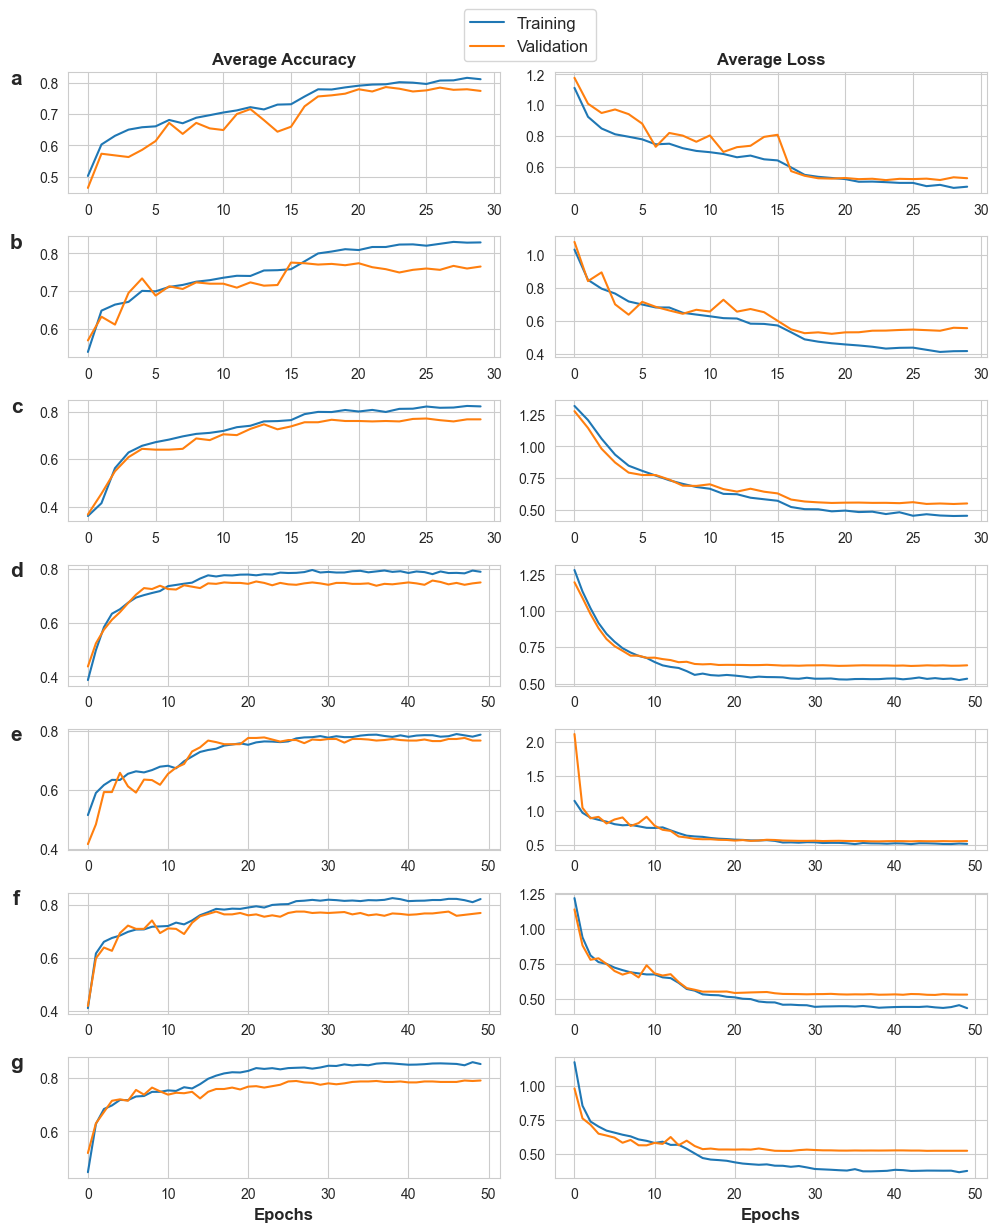

In [39]:
train_avg_acc_list = [train_acc_avg_densenet121_3d, train_acc_avg_resnet26_3d, train_acc_avg_resnet50_3d, train_acc_avg_mobilenetv2_050_2d, train_acc_avg_resnet26_2d, train_acc_avg_resnet50_2d, train_acc_avg_cait_s24_224_2d]
train_avg_loss_list = [train_loss_avg_densenet121_3d, train_loss_avg_resnet26_3d, train_loss_avg_resnet50_3d, train_loss_avg_mobilenetv2_050_2d, train_loss_avg_resnet26_2d, train_loss_avg_resnet50_2d, train_loss_avg_cait_s24_224_2d]
val_avg_acc_list = [val_acc_avg_densenet121_3d, val_acc_avg_resnet26_3d, val_acc_avg_resnet50_3d, val_acc_avg_mobilenetv2_050_2d, val_acc_avg_resnet26_2d, val_acc_avg_resnet50_2d, val_acc_avg_cait_s24_224_2d]
val_avg_loss_list = [val_loss_avg_densenet121_3d, val_loss_avg_resnet26_3d, val_loss_avg_resnet50_3d, val_loss_avg_mobilenetv2_050_2d, val_loss_avg_resnet26_2d, val_loss_avg_resnet50_2d, val_loss_avg_cait_s24_224_2d]

models_names_3d = ['DenseNet121 (3D)', 'ResNet26 (3D)', 'ResNet50 (3D)', 'MobileNetV2 (2D)', 'ResNet26 (2D)', 'ResNet50 (2D)', 'CaiT-S24 (2D)']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

fig, axes = plt.subplots(7, 2, figsize=(10, 12))
axes = axes.flatten()

lines = []
labels = ['Training', 'Validation']

for i, ax in enumerate(axes):
    if i % 2 == 0:
        if i<=5:
            line1, = ax.plot(np.arange(30), train_avg_acc_list[i//2], label='Train Accuracy')
            line2, = ax.plot(np.arange(30), val_avg_acc_list[i//2], label='Validation Accuracy')
        else:
            line1, = ax.plot(np.arange(50), train_avg_acc_list[i//2], label='Train Accuracy')
            line2, = ax.plot(np.arange(50), val_avg_acc_list[i//2], label='Validation Accuracy')
        lines.append(line1)
        lines.append(line2)
        axes[i].text(-0.12, 0.9, alphabet[i//2], horizontalalignment='center', transform=axes[i].transAxes, fontsize=15, fontweight='bold')
        if i == 0:
            ax.set_title('Average Accuracy', fontweight='bold', fontsize=12)
        if i == 12:
            ax.set_xlabel("Epochs", fontweight='bold', fontsize=12)
             
    else:
        if i<=5:
            line1, = ax.plot(np.arange(30), train_avg_loss_list[i//2], label='Train Accuracy')
            line2, = ax.plot(np.arange(30), val_avg_loss_list[i//2], label='Validation Accuracy')
        else:
            line1, = ax.plot(np.arange(50), train_avg_loss_list[i//2], label='Train Accuracy')
            line2, = ax.plot(np.arange(50), val_avg_loss_list[i//2], label='Validation Accuracy')
        lines.append(line1)
        lines.append(line2)
        if i == 1:
            ax.set_title('Average Loss', fontweight='bold', fontsize=12)
        if i == 13:
            ax.set_xlabel("Epochs", fontweight='bold', fontsize=12)


# Create a common legend outside the plot area
fig.legend(lines[:2], labels, loc='upper center', bbox_to_anchor=(0.525, 1.03), fontsize=12)
plt.tight_layout()
plt.show()
fig.savefig("G:/Paper Manuscript/Figures/fig2.tiff", dpi=1200, bbox_inches='tight', format='tiff')

# Confusion Matrix of 3D and 2D Models

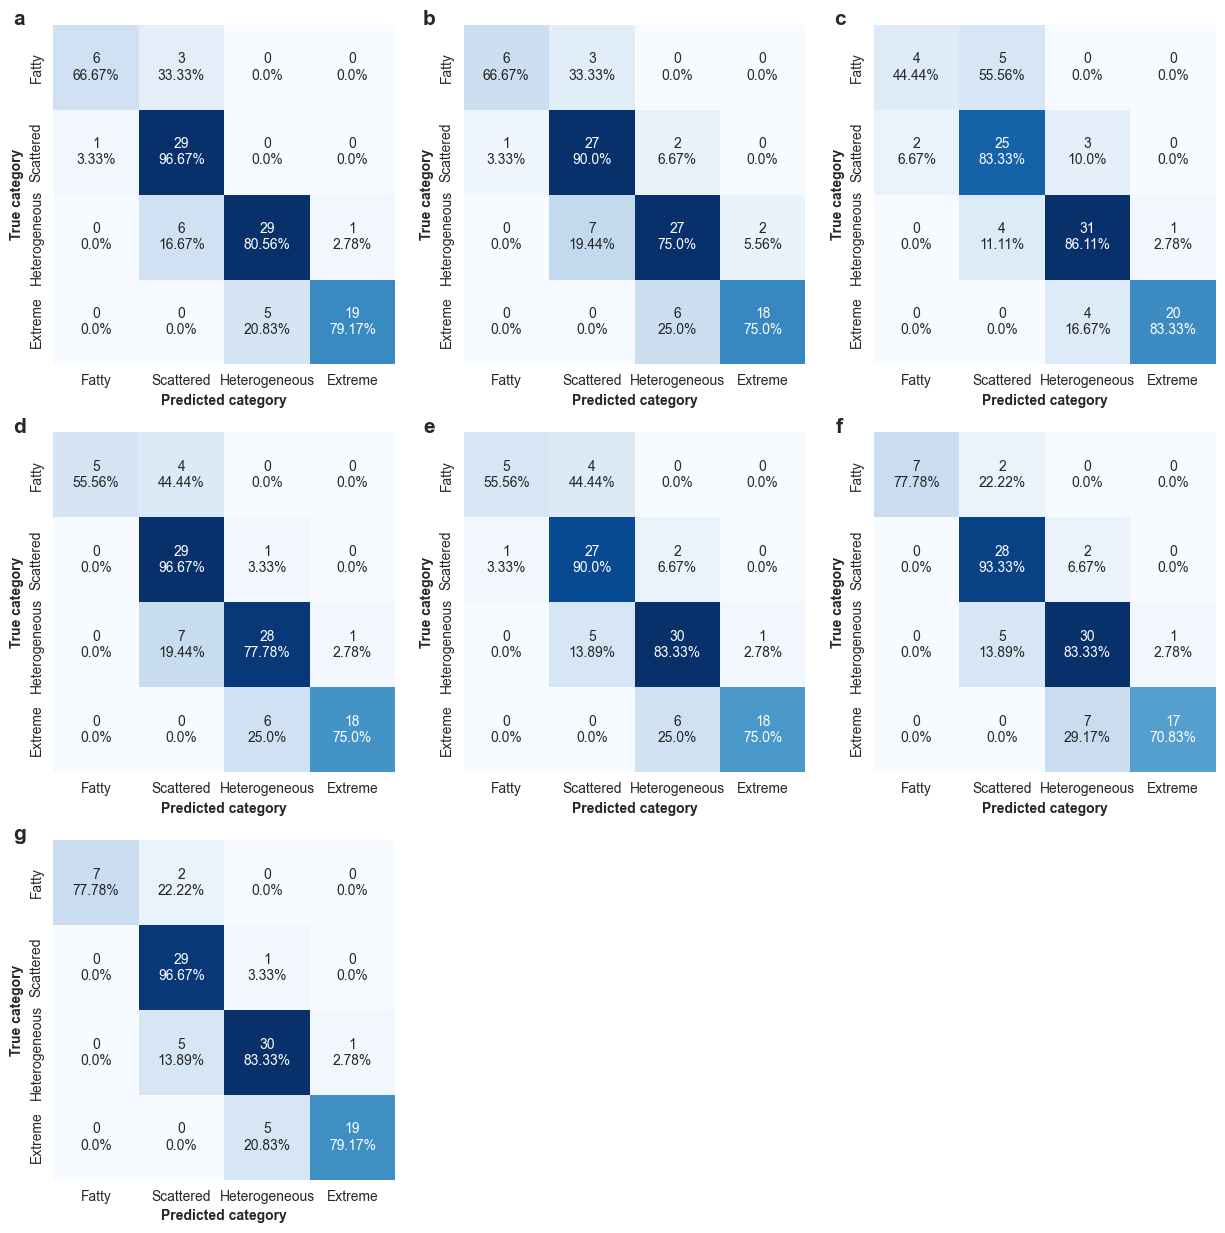

In [23]:
best_models_list = [densenet121_3d_best_model, resnet26_3d_best_model, resnet50_3d_best_model, mobilenetv2_050_best_model, resnet26_best_model, resnet50_best_model, cait_s24_224_best_model]

# models_names = ['DenseNet121', 'ResNet26', 'ResNet50']
cm_labels = ['Fatty', 'Scattered', 'Heterogeneous', 'Extreme']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# fig.suptitle('Confusion Matrix of 3D Models', fontsize=16)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i>=7:
        axes[i].axis('off')
        continue
    if i<=2:
        y_pred_best, best_accuracy, _ = test_model(best_models_list[i], test_data_left_3d, test_data_right_3d, y_test, batch_size=1, is_3d=True)
    else:
        y_pred_best, best_accuracy, _ = test_model(best_models_list[i], test_data_left_2d, test_data_right_2d, y_test, batch_size=1, is_3d=False)
        
    cm = confusion_matrix(y_test, y_pred_best)
    cm_df = pd.DataFrame(cm, index=[i for i in range(4)], columns=[i for i in range(4)])
    cm_perc = cm_df /  np.sum(cm_df.to_numpy(), axis=1, keepdims=True) * 100
    cm_perc = cm_perc.round(2)
    annotations = cm_df.astype(str) + '\n' + cm_perc.astype(str) + '%'
    
    sns.heatmap(cm_df, ax=ax, annot=annotations, fmt='', cmap='Blues', cbar=False, xticklabels=cm_labels, yticklabels=cm_labels)
    # ax.set_title(f"Model Name: {models_names[i]}\n(Accuracy: {best_accuracy:.2f}) ")
    axes[i].text(-0.1, 1, alphabet[i], horizontalalignment='center', transform=axes[i].transAxes, fontsize=15, fontweight='bold')
    ax.set_xlabel("Predicted category", fontweight='bold', fontsize=10)
    ax.set_ylabel("True category", fontweight='bold', fontsize=10)

# plt.tight_layout()
plt.show()
fig.savefig("G:/Paper Manuscript/Figs/fig3.tiff", dpi=600, bbox_inches='tight', format='tiff')

# ROC Curves of 2D and 3D Models

In [42]:
from sklearn.metrics import auc, roc_curve

In [74]:
def display_ROC(y_train, y_test, output_probability, name, color, chance_level=False):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    display = RocCurveDisplay.from_predictions(
        y_onehot_test.ravel(),
        output_probability.ravel(),
        name=name,
        color=color,
        plot_chance_level=chance_level,
    )
    
    return display

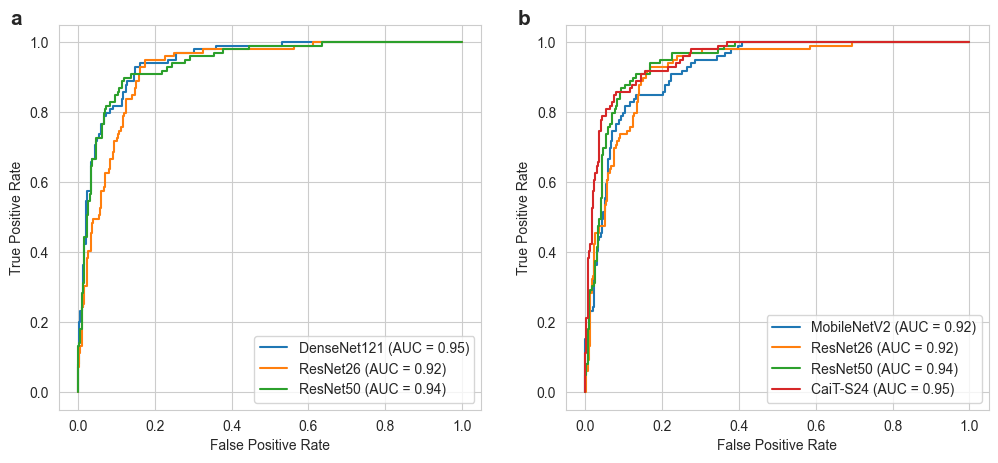

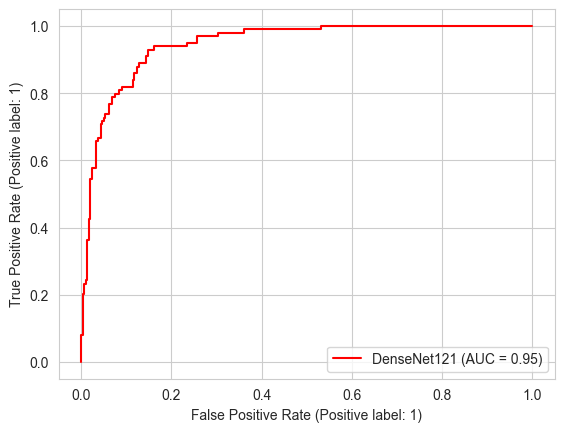

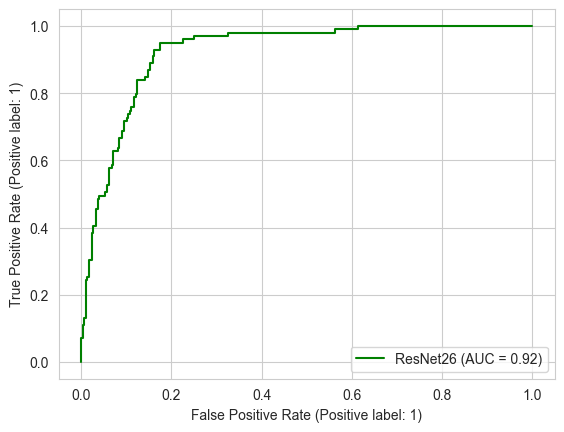

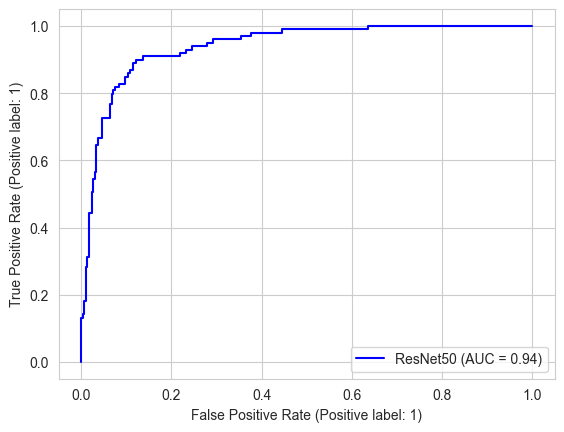

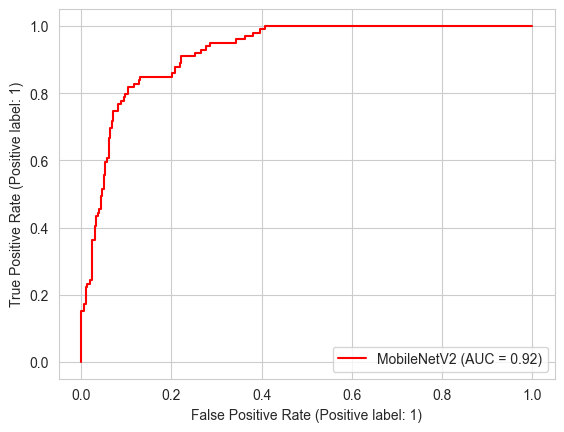

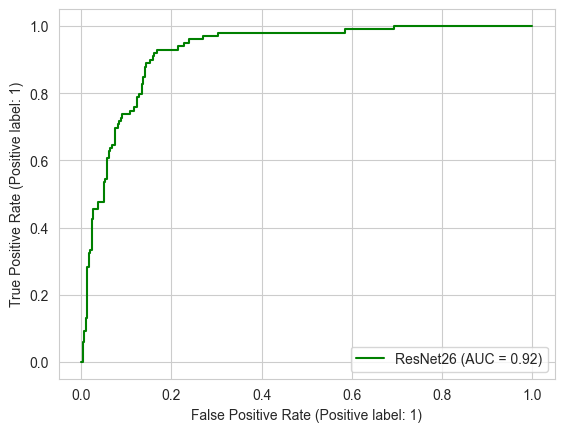

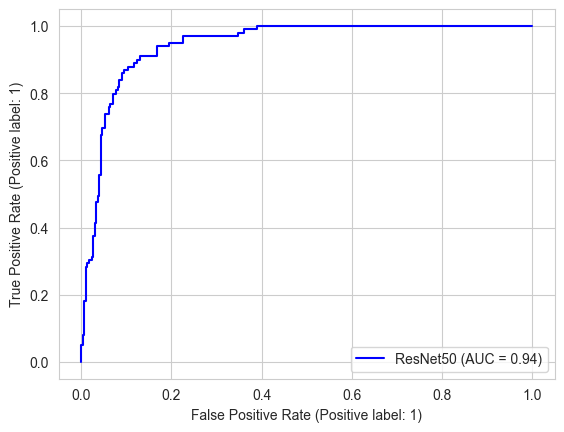

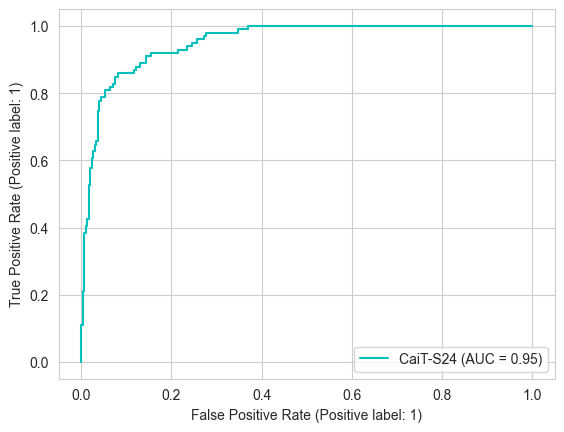

In [78]:
outputs_probability_2d = [output_probability_best_mobilenetv2_050, output_probability_best_resnet26, output_probability_best_resnet50,
              output_probability_best_cait_s24_224]

outputs_probability_3d = [output_probability_best_densenet121_3d, output_probability_best_resnet26_3d, output_probability_best_resnet50_3d]

models_names_2d = ['MobileNetV2', 'ResNet26', 'ResNet50', 'CaiT-S24']
models_names_3d = ['DenseNet121', 'ResNet26', 'ResNet50']
colors = ['r', 'g', 'b', 'c']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
    
for idx, p in enumerate(outputs_probability_3d):
    display = display_ROC(y_train, y_test, p, models_names_3d[idx], colors[idx])
    display.plot(axes[0])
    _ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    )
    
for idx, p in enumerate(outputs_probability_2d):
    display = display_ROC(y_train, y_test, p, models_names_2d[idx], colors[idx])
    display.plot(axes[1])
    _ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    )

axes[0].text(-0.1, 1, "a", horizontalalignment='center', transform=axes[0].transAxes, fontsize=15, fontweight='bold')
axes[1].text(-0.1, 1, "b", horizontalalignment='center', transform=axes[1].transAxes, fontsize=15, fontweight='bold')

fig.savefig("G:/Paper Manuscript/Figs/fig4.tiff", dpi=1200, bbox_inches='tight', format='tiff')

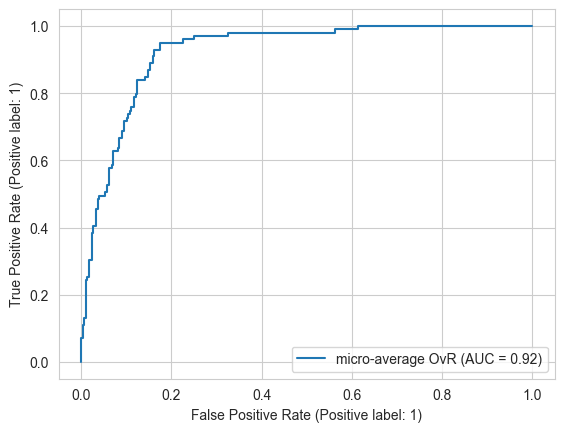

In [94]:
display2.plot()

# Show What 2D Models Have Learned

In [23]:
data_path = "E:/2D Dataset\Independent Test/test_data_percentiles_right.npy"
test_data = np.load("E:/2D Dataset\Independent Test/test_data_percentiles_right.npy").transpose(0, 2, 3, 1)

mobilenetv2_050_target_layer = mobilenetv2_050_best_model.blocks[-1]
resnet26_target_layer = resnet26_best_model.layer4[-1]
resnet50_target_layer = resnet50_best_model.layer4[-1]
cait_s24_224_target_layer = cait_s24_224_best_model.blocks[-1].norm1

data_idx_class_0 = [0, 46]
grad_cam_images_class_0_mobilenetv2_050 = get_grad_cam(mobilenetv2_050_best_model, mobilenetv2_050_target_layer, test_data_right_2d, data_path, data_idx_class_0, type=7)
grad_cam_images_class_0_resnet26 = get_grad_cam(resnet26_best_model, resnet26_target_layer, test_data_right_2d, data_path, data_idx_class_0, type=10)
grad_cam_images_class_0_resnet50 = get_grad_cam(resnet50_best_model, resnet50_target_layer, test_data_right_2d, data_path, data_idx_class_0, type=10)
grad_cam_images_class_0_cait_s24_224 = get_grad_cam(cait_s24_224_best_model, cait_s24_224_target_layer, test_data_right_2d, data_path, data_idx_class_0, type=7, reshape_transform=reshape_transform)

data_idx_class_1 = [36, 42]
grad_cam_images_class_1_mobilenetv2_050 = get_grad_cam(mobilenetv2_050_best_model, mobilenetv2_050_target_layer, test_data_right_2d, data_path, data_idx_class_1, type=7)
grad_cam_images_class_1_resnet26 = get_grad_cam(resnet26_best_model, resnet26_target_layer, test_data_right_2d, data_path, data_idx_class_1, type=10)
grad_cam_images_class_1_resnet50 = get_grad_cam(resnet50_best_model, resnet50_target_layer, test_data_right_2d, data_path, data_idx_class_1, type=10)
grad_cam_images_class_1_cait_s24_224 = get_grad_cam(cait_s24_224_best_model, cait_s24_224_target_layer, test_data_right_2d, data_path, data_idx_class_1, type=7, reshape_transform=reshape_transform)

data_idx_class_2 = [18, 39]
grad_cam_images_class_2_mobilenetv2_050 = get_grad_cam(mobilenetv2_050_best_model, mobilenetv2_050_target_layer, test_data_right_2d, data_path, data_idx_class_2, type=7)
grad_cam_images_class_2_resnet26 = get_grad_cam(resnet26_best_model, resnet26_target_layer, test_data_right_2d, data_path, data_idx_class_2, type=10)
grad_cam_images_class_2_resnet50 = get_grad_cam(resnet50_best_model, resnet50_target_layer, test_data_right_2d, data_path, data_idx_class_2, type=10)
grad_cam_images_class_2_cait_s24_224 = get_grad_cam(cait_s24_224_best_model, cait_s24_224_target_layer, test_data_right_2d, data_path, data_idx_class_2, type=7, reshape_transform=reshape_transform)

data_idx_class_3 = [31, 64]
grad_cam_images_class_3_mobilenetv2_050 = get_grad_cam(mobilenetv2_050_best_model, mobilenetv2_050_target_layer, test_data_right_2d, data_path, data_idx_class_3, type=7)
grad_cam_images_class_3_resnet26 = get_grad_cam(resnet26_best_model, resnet26_target_layer, test_data_right_2d, data_path, data_idx_class_3, type=10)
grad_cam_images_class_3_resnet50 = get_grad_cam(resnet50_best_model, resnet50_target_layer, test_data_right_2d, data_path, data_idx_class_3, type=10)
grad_cam_images_class_3_cait_s24_224 = get_grad_cam(cait_s24_224_best_model, cait_s24_224_target_layer, test_data_right_2d, data_path, data_idx_class_3, type=7, reshape_transform=reshape_transform)

images_idx_list = [46, 36, 18, 64]
first_row = []
for idx in images_idx_list:
    img = cv2.imread("first_row/2D/" + str(idx) + ".png")
    img = cv2.resize(img, (224, 224))
    first_row.append(img)

second_row = [grad_cam_images_class_0_mobilenetv2_050[1],
              grad_cam_images_class_1_mobilenetv2_050[0],
              grad_cam_images_class_2_mobilenetv2_050[0],
              grad_cam_images_class_3_mobilenetv2_050[1],]

third_row = [grad_cam_images_class_0_resnet26[1],
             grad_cam_images_class_1_resnet26[0],
             grad_cam_images_class_2_resnet26[0],
             grad_cam_images_class_3_resnet26[1],]

fourth_row = [grad_cam_images_class_0_resnet50[1], 
              grad_cam_images_class_1_resnet50[0], 
              grad_cam_images_class_2_resnet50[0], 
              grad_cam_images_class_3_resnet50[1],]

fifth_row = [grad_cam_images_class_0_cait_s24_224[1], 
             grad_cam_images_class_1_cait_s24_224[0], 
             grad_cam_images_class_2_cait_s24_224[0], 
             grad_cam_images_class_3_cait_s24_224[1],]

grad_cam_all_data = np.array([first_row, second_row, third_row, fourth_row, fifth_row])

In [24]:
images_idx_list = [46, 36, 18, 64]

first_row = []
for idx in images_idx_list:
    img = cv2.imread("first_row/2D/" + str(idx) + ".png")
    img = cv2.resize(img, (224, 224))
    first_row.append(img)

second_row = []
for i in range(4):
    img_rgb = cv2.cvtColor(cv2.imread(f"first_row/GradCam 2D/MobileNetV2/{i}.png"), cv2.COLOR_BGR2RGB)
    second_row.append(img_rgb)
    
third_row = []
for i in range(4):
    img_rgb = cv2.cvtColor(cv2.imread(f"first_row/GradCam 2D/ResNet26/{i}.png"), cv2.COLOR_BGR2RGB)
    third_row.append(img_rgb)
    
fourth_row = []
for i in range(4):
    img_rgb = cv2.cvtColor(cv2.imread(f"first_row/GradCam 2D/ResNet50/{i}.png"), cv2.COLOR_BGR2RGB)
    fourth_row.append(img_rgb)
    
fifth_row = []
for i in range(4):
    img_rgb = cv2.cvtColor(cv2.imread(f"first_row/GradCam 2D/CaiTS24/{i}.png"), cv2.COLOR_BGR2RGB)
    fifth_row.append(img_rgb)
    
grad_cam_all_data = np.array([first_row, second_row, third_row, fourth_row, fifth_row])

C:\Users\Meysam\AppData\Local\Temp\ipykernel_8560\194815591.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grad_cam_all_data = np.array([first_row, second_row, third_row, fourth_row, fifth_row])


C:\Users\Meysam\AppData\Local\Temp\ipykernel_8560\4254246000.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


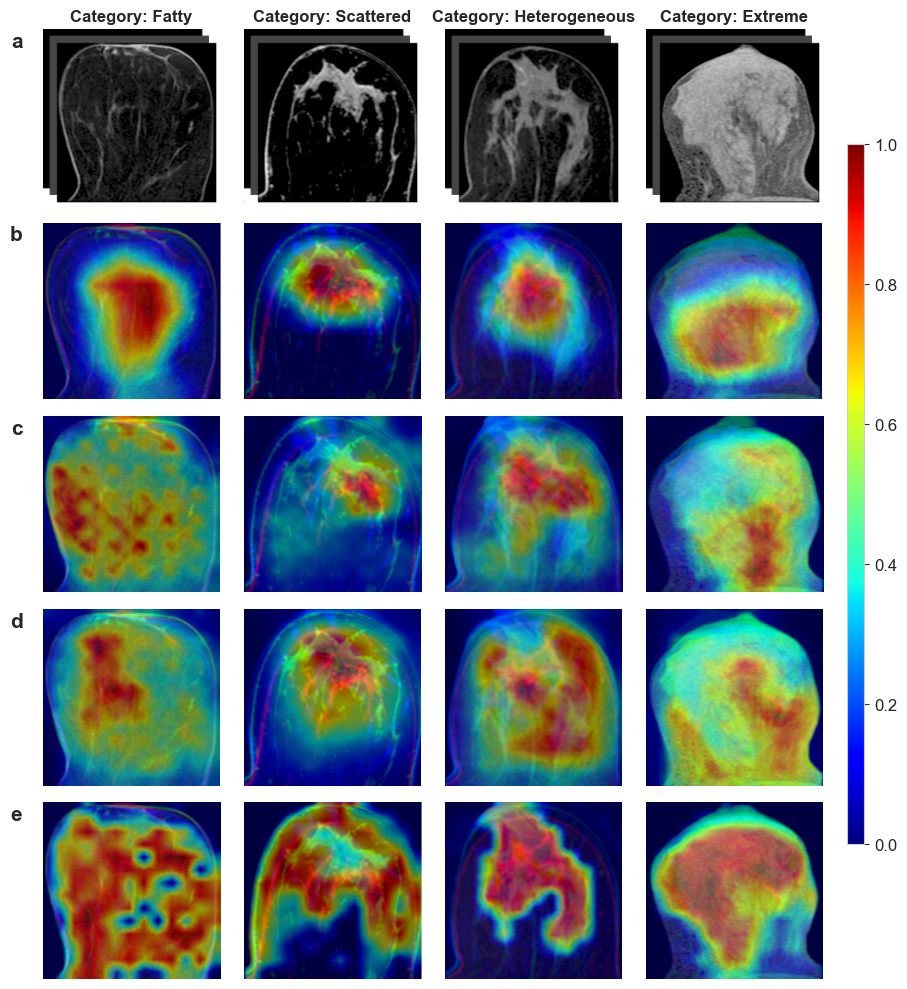

In [25]:
class_list = ['Fatty', 'Scattered', 'Heterogeneous', 'Extreme']
alphabet_list = ['a', 'b', 'c', 'd', 'e']

fig, axes = plt.subplots(5, 4, figsize=(8.5, 10))

for i in range(5):
    axes[i, 0].text(-0.15, 0.9, alphabet_list[i], horizontalalignment='center', transform=axes[i, 0].transAxes, fontsize=15, fontweight='bold')
    for j in range(4):
        if i == 0:
            axes[i, j].imshow(grad_cam_all_data[i, j], cmap='gray')
            axes[i, j].set_title(f"Category: {class_list[j]}", fontsize=12, fontweight='bold')
            axes[i, j].axis('off')
        else:
            im = axes[i, j].imshow(grad_cam_all_data[i, j]/np.max(grad_cam_all_data[i, j]), cmap='jet')
            axes[i, j].axis('off')
            
cax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position as needed
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

fig.savefig("G:/Paper Manuscript/Figures/fig6.tiff", dpi=600, bbox_inches='tight', format='tiff')

# Show What 3D Models Have Learned

In [ ]:
pca = PCA(n_components=1)

volume_idx_list = [46, 36, 18, 64]

first_row = []
for idx in volume_idx_list:
    img = cv2.imread("first_row/3D/" + str(idx) + ".png", cv2.IMREAD_GRAYSCALE)
    first_row.append(img.astype(np.float32))
    
second_row = []
for idx in volume_idx_list:
    img = sitk.ReadImage(f"attention_maps/densenet121/features/attention_map_{idx}_0_0.nii.gz")
    img = sitk.GetArrayFromImage(img).transpose(0, 2, 1)
    grad_cam_2d = pca.fit_transform(img.reshape(-1, 96)).reshape(140, 140).astype(np.float32)
    grad_cam_2d = (grad_cam_2d-grad_cam_2d.min())/(grad_cam_2d.max()-grad_cam_2d.min())
    grad_cam_2d = cv2.cvtColor(grad_cam_2d,cv2.COLOR_GRAY2RGB)
    second_row.append(grad_cam_2d)

third_row = []
for idx in volume_idx_list:
    img = sitk.ReadImage(f"attention_maps/resnet26/layer4/attention_map_{idx}_0_0.nii.gz")
    img = sitk.GetArrayFromImage(img).transpose(0, 2, 1)
    grad_cam_2d = pca.fit_transform(img.reshape(-1, 96)).reshape(140, 140).astype(np.float32)
    grad_cam_2d = (grad_cam_2d-grad_cam_2d.min())/(grad_cam_2d.max()-grad_cam_2d.min())
    grad_cam_2d = cv2.cvtColor(grad_cam_2d,cv2.COLOR_GRAY2RGB) 
    third_row.append(grad_cam_2d)
    
fourth_row = []
for idx in volume_idx_list:
    img = sitk.ReadImage(f"attention_maps/resnet50/layer4/attention_map_{idx}_0_0.nii.gz")
    img = sitk.GetArrayFromImage(img).transpose(0, 2, 1)
    grad_cam_2d = pca.fit_transform(img.reshape(-1, 96)).reshape(140, 140).astype(np.float32)
    grad_cam_2d = (grad_cam_2d-grad_cam_2d.min())/(grad_cam_2d.max()-grad_cam_2d.min())
    grad_cam_2d = cv2.cvtColor(grad_cam_2d,cv2.COLOR_GRAY2RGB) 
    fourth_row.append(grad_cam_2d)
    
grad_cam_all_data = np.array([first_row, second_row, third_row, fourth_row])

In [23]:
volume_idx_list = [46, 36, 18, 64]

first_row = []
for idx in volume_idx_list:
    img = cv2.imread("first_row/3D/" + str(idx) + ".png")
    img = cv2.resize(img, (224, 224))
    first_row.append(img)

second_row = []
for i in range(4):
    img_rgb = cv2.cvtColor(cv2.imread(f"first_row/GradCam 3D/DenseNet121/{i}.png"), cv2.COLOR_BGR2RGB)
    second_row.append(img_rgb)
    
third_row = []
for i in range(4):
    img_rgb = cv2.cvtColor(cv2.imread(f"first_row/GradCam 3D/ResNet26/{i}.png"), cv2.COLOR_BGR2RGB)
    third_row.append(img_rgb)
    
fourth_row = []
for i in range(4):
    img_rgb = cv2.cvtColor(cv2.imread(f"first_row/GradCam 3D/ResNet50/{i}.png"), cv2.COLOR_BGR2RGB)
    fourth_row.append(img_rgb)
    
grad_cam_all_data = np.array([first_row, second_row, third_row, fourth_row])

C:\Users\Meysam\AppData\Local\Temp\ipykernel_6280\823812745.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grad_cam_all_data = np.array([first_row, second_row, third_row, fourth_row])


C:\Users\Meysam\AppData\Local\Temp\ipykernel_6280\3847887375.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


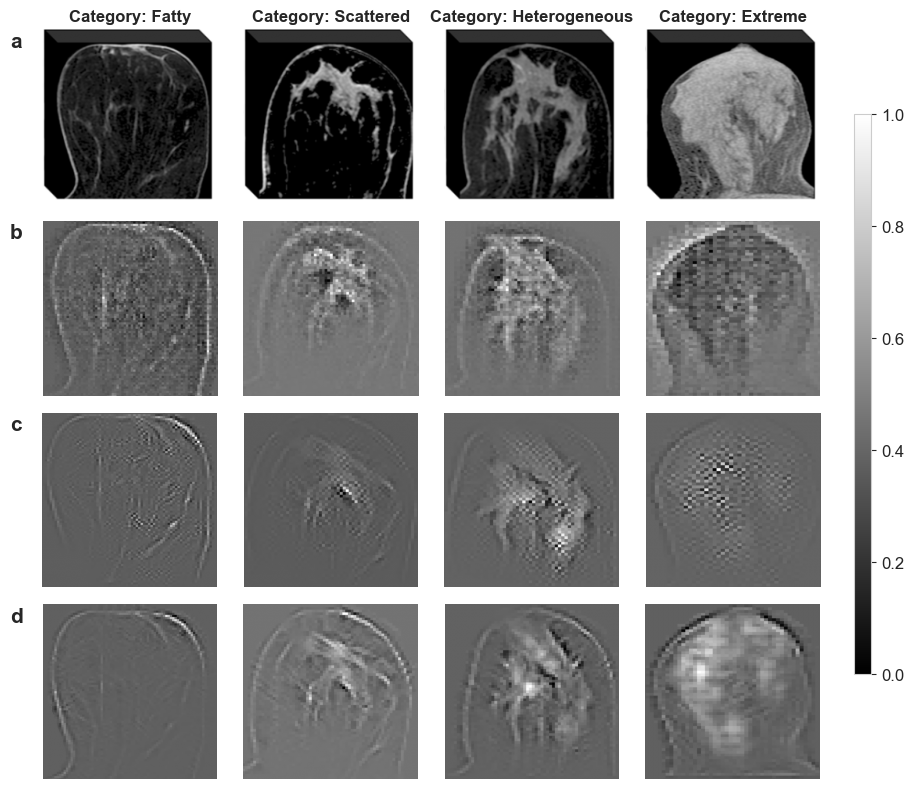

In [25]:
class_list = ['Fatty', 'Scattered', 'Heterogeneous', 'Extreme']
alphabet_list = ['a', 'b', 'c', 'd', 'e']

fig, axes = plt.subplots(4, 4, figsize=(8.5, 8))

for i in range(4):
    axes[i, 0].text(-0.15, 0.9, alphabet_list[i], horizontalalignment='center', transform=axes[i, 0].transAxes, fontsize=15, fontweight='bold')
    for j in range(4):
        if i == 0:
            axes[i, j].imshow(grad_cam_all_data[i, j]/np.max(grad_cam_all_data[i, j]), cmap='gray')
            axes[i, j].set_title(f"Category: {class_list[j]}", fontweight='bold')
            axes[i, j].axis('off')
        else:
            im = axes[i, j].imshow(grad_cam_all_data[i, j]/np.max(grad_cam_all_data[i, j]), cmap='gray')
            axes[i, j].axis('off')
                
cax = fig.add_axes([1.01, 0.15, 0.02, 0.7])  
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

fig.savefig("G:/Paper Manuscript/Figures/fig5.tiff", dpi=300, bbox_inches='tight', format='tiff')

# McNemar's Test

In [62]:
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

y_pred_all = [y_pred_best_mobilenetv2_050, y_pred_best_resnet26, y_pred_best_resnet50, y_pred_best_cait_s24_224, y_pred_best_densenet121_3d, y_pred_best_resnet26_3d, y_pred_best_resnet50_3d]

In [66]:
models_names = ['MobileNetV2', '2DResNet26', '2DResNet50', 'CaiT-S24', 'DenseNet121', '3DResNet26', '3DResNet50']

for i, name1 in enumerate(models_names):
    for j, name2 in enumerate(models_names):
        if j>i:
            tb = mcnemar_table(y_target=y_test, y_model1=y_pred_all[i], y_model2=y_pred_all[j])
            chi2, p = mcnemar(ary=tb, exact=True)
            print(f"P-Value of {name1}/{name2} = {p:.3f}")

P-Value of MobileNetV2/2DResNet26 = 1.000
P-Value of MobileNetV2/2DResNet50 = 0.754
P-Value of MobileNetV2/CaiT-S24 = 0.180
P-Value of MobileNetV2/DenseNet121 = 0.508
P-Value of MobileNetV2/3DResNet26 = 0.804
P-Value of MobileNetV2/3DResNet50 = 1.000
P-Value of 2DResNet26/2DResNet50 = 0.774
P-Value of 2DResNet26/CaiT-S24 = 0.180
P-Value of 2DResNet26/DenseNet121 = 0.629
P-Value of 2DResNet26/3DResNet26 = 0.824
P-Value of 2DResNet26/3DResNet50 = 1.000
P-Value of 2DResNet50/CaiT-S24 = 0.453
P-Value of 2DResNet50/DenseNet121 = 1.000
P-Value of 2DResNet50/3DResNet26 = 0.481
P-Value of 2DResNet50/3DResNet50 = 0.824
P-Value of CaiT-S24/DenseNet121 = 0.804
P-Value of CaiT-S24/3DResNet26 = 0.167
P-Value of CaiT-S24/3DResNet50 = 0.302
P-Value of DenseNet121/3DResNet26 = 0.302
P-Value of DenseNet121/3DResNet50 = 0.581
P-Value of 3DResNet26/3DResNet50 = 0.815
